[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1972bNHN_BBTEorvLxqTvdRS4nC3PWj7O#scrollTo=jTQTcDbj9uxr)

### TMDB Box Office Prediction

**[1. Data loading and overview](#heading--1)**

**[2. Exploratory Data Analysis](#heading--2)**

  * [2.1. target variable revenue](#heading--2-1)
  * [2.2. belongs_to_collection column](#heading--2-2)
  * [2.3. genres column](#heading--2-3)
  * [2.4. production_companies column](#heading--2-4)
  * [2.5. production_countries column](#heading--2-5)
  * [2.6. spoken_languages column](#heading--2-6)
  * [2.7. Keywords column](#heading--2-7)
  * [2.8. cast column](#heading--2-8)
  * [2.9. crew column](#heading--2-9)
  * [2.10. homepage column](#heading--2-10)
  * [2.11. imdb_id column](#heading--2-11)
  * [2.12. original_language column](#heading--2-12)
  * [2.13. original_title column](#heading--2-13)
  * [2.14. overview column](#heading--2-14)
  * [2.15. popularity column](#heading--2-15)
  * [2.16. poster_path column](#heading--2-16)
  * [2.17. release_date column](#heading--2-17)
  * [2.18. runtime column](#heading--2-18)
  * [2.19. status column](#heading--2-19)
  * [2.20. tagline column](#heading--2-20)
  * [2.21. title column](#heading--2-21)
  * [2.22. budget column](#heading--2-22)

**[3. Data Preprocessing](#heading--3)**

  * [3.1. Correlation with revenue](#heading--3-1)
  * [3.2. Adding new features](#heading--3-2)
  * [3.3. Data Transformation](#heading--3-3)

**[4. Model Training and prediction](#heading--4)**

  * [4.1. Initializing the models](#heading--4-1)
  * [4.2. Comparing different models](#heading--4-2)
  * [4.3. Improvement the result of the best model](#heading--4-3)
  



In [464]:
import numpy as np
import pandas as pd
import ast
from collections import Counter
import time
from scipy.stats import skew

import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.float_format', lambda x: '%.4f' % x)
sns.set()

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xg
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV


### 1. Data loading and overview <a name="heading--1"/>


In [207]:
# Loading train and test data
train_raw = pd.read_csv('train.csv')
test_raw = pd.read_csv('test.csv')

# copying of original data
train = train_raw.copy()
test = test_raw.copy()

# Id from test set is necessary to submit the file on Kaggle
test_id = test['id']

In [208]:
train.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.5754,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0000,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.2489,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0000,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.3000,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0000,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.1749,/aTXRaPrWSinhcmCrcfJK17urp3F.jpg,NaN,"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/12,122.0000,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.1481,/m22s7zvkVFDU9ir56PiiqIEWFdT.jpg,NaN,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2/5/09,118.0000,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970


In [209]:
test.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew
0,3001,"[{'id': 34055, 'name': 'Pokémon Collection', '...",0,"[{'id': 12, 'name': 'Adventure'}, {'id': 16, '...",http://www.pokemon.com/us/movies/movie-pokemon...,tt1226251,ja,ディアルガVSパルキアVSダークライ,Ash and friends (this time accompanied by newc...,3.8515,/tnftmLMemPLduW6MRyZE0ZUD19z.jpg,NaN,"[{'iso_3166_1': 'JP', 'name': 'Japan'}, {'iso_...",7/14/07,90.0000,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Somewhere Between Time & Space... A Legend Is ...,Pokémon: The Rise of Darkrai,"[{'id': 11451, 'name': 'pok√©mon'}, {'id': 115...","[{'cast_id': 3, 'character': 'Tonio', 'credit_...","[{'credit_id': '52fe44e7c3a368484e03d683', 'de..."
1,3002,NaN,88000,"[{'id': 27, 'name': 'Horror'}, {'id': 878, 'na...",NaN,tt0051380,en,Attack of the 50 Foot Woman,When an abused wife grows to giant size becaus...,3.5598,/9MgBNBqlH1sG4yG2u4XkwI5CoJa.jpg,"[{'name': 'Woolner Brothers Pictures Inc.', 'i...","[{'iso_3166_1': 'US', 'name': 'United States o...",5/19/58,65.0000,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A titanic beauty spreads a macabre wave of hor...,Attack of the 50 Foot Woman,"[{'id': 9748, 'name': 'revenge'}, {'id': 9951,...","[{'cast_id': 2, 'character': 'Nancy Fowler Arc...","[{'credit_id': '55807805c3a3685b1300060b', 'de..."
2,3003,NaN,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",NaN,tt0118556,en,Addicted to Love,Good-natured astronomer Sam is devastated when...,8.0852,/ed6nD7h9sbojSWY2qrnDcSvDFko.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",5/23/97,100.0000,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A Comedy About Lost Loves And Last Laughs,Addicted to Love,"[{'id': 931, 'name': 'jealousy'}, {'id': 9673,...","[{'cast_id': 11, 'character': 'Maggie', 'credi...","[{'credit_id': '52fe4330c3a36847f8041367', 'de..."
3,3004,NaN,6800000,"[{'id': 18, 'name': 'Drama'}, {'id': 10752, 'n...",http://www.sonyclassics.com/incendies/,tt1255953,fr,Incendies,A mother's last wishes send twins Jeanne and S...,8.5960,/sEUG3qjxwHjxkzuO7plrRHhOZUH.jpg,"[{'name': 'TS Productions', 'id': 313}, {'name...","[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...",9/4/10,130.0000,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",Released,The search began at the opening of their mothe...,Incendies,"[{'id': 378, 'name': 'prison'}, {'id': 539, 'n...","[{'cast_id': 6, 'character': 'Nawal', 'credit_...","[{'credit_id': '56478092c3a36826140043af', 'de..."
4,3005,NaN,2000000,"[{'id': 36, 'name': 'History'}, {'id': 99, 'na...",NaN,tt0418753,en,Inside Deep Throat,"In 1972, a seemingly typical shoestring budget...",3.2177,/n4WC3zbelz6SG7rhkWbf8m9pMHB.jpg,NaN,"[{'iso_3166_1': 'US', 'name': 'United States o...",2/11/05,92.0000,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It was filmed in 6 days for 25 thousand dollar...,Inside Deep Throat,"[{'id': 279, 'name': 'usa'}, {'id': 1228, 'nam...","[{'cast_id': 1, 'character': 'Narrator (voice)...","[{'credit_id': '52fe44ce9251416c75041967', 'de..."


In [210]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     3000 non-null   int64  
 1   belongs_to_collection  604 non-null    object 
 2   budget                 3000 non-null   int64  
 3   genres                 2993 non-null   object 
 4   homepage               946 non-null    object 
 5   imdb_id                3000 non-null   object 
 6   original_language      3000 non-null   object 
 7   original_title         3000 non-null   object 
 8   overview               2992 non-null   object 
 9   popularity             3000 non-null   float64
 10  poster_path            2999 non-null   object 
 11  production_companies   2844 non-null   object 
 12  production_countries   2945 non-null   object 
 13  release_date           3000 non-null   object 
 14  runtime                2998 non-null   float64
 15  spok

In [211]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4398 entries, 0 to 4397
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4398 non-null   int64  
 1   belongs_to_collection  877 non-null    object 
 2   budget                 4398 non-null   int64  
 3   genres                 4382 non-null   object 
 4   homepage               1420 non-null   object 
 5   imdb_id                4398 non-null   object 
 6   original_language      4398 non-null   object 
 7   original_title         4398 non-null   object 
 8   overview               4384 non-null   object 
 9   popularity             4398 non-null   float64
 10  poster_path            4397 non-null   object 
 11  production_companies   4140 non-null   object 
 12  production_countries   4296 non-null   object 
 13  release_date           4397 non-null   object 
 14  runtime                4394 non-null   float64
 15  spok

In [212]:
# some basic statistics for numerical columns
train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,3000.0000,1500.5000,866.1697,1.0000,750.7500,1500.5000,2250.2500,3000.0000
budget,3000.0000,22531334.1100,37026086.4120,0.0000,0.0000,8000000.0000,29000000.0000,380000000.0000
popularity,3000.0000,8.4633,12.1040,0.0000,4.0181,7.3749,10.8910,294.3370
runtime,2998.0000,107.8566,22.0864,0.0000,94.0000,104.0000,118.0000,338.0000
revenue,3000.0000,66725851.8887,137532326.3360,1.0000,2379808.2500,16807068.0000,68919203.5000,1519557910.0000


In [213]:
test.describe().T

,count,mean,std,min,25%,50%,75%,max
id,4398.0000,5199.5000,1269.7376,3001.0000,4100.2500,5199.5000,6298.7500,7398.0000
budget,4398.0000,22649291.1173,36899910.8813,0.0000,0.0000,7450000.0000,28000000.0000,260000000.0000
popularity,4398.0000,8.5502,12.2090,0.0000,3.8952,7.4822,10.9385,547.4883
runtime,4394.0000,107.6222,21.0583,0.0000,94.0000,104.0000,118.0000,320.0000


In [214]:
# some basic statistics for object columns
train.describe(include=['object']).T

,count,unique,top,freq
belongs_to_collection,604,422,"[{'id': 645, 'name': 'James Bond Collection', ...",16
genres,2993,872,"[{'id': 18, 'name': 'Drama'}]",266
homepage,946,941,http://www.transformersmovie.com/,4
imdb_id,3000,3000,tt1216487,1
original_language,3000,36,en,2575
original_title,3000,2975,Fantastic Four,2
overview,2992,2992,"As we follow a mother and her son, we delve in...",1
poster_path,2999,2999,/q429dpKlVP8uTrWJ7Tq9UFEQ8ww.jpg,1
production_companies,2844,2383,"[{'name': 'Paramount Pictures', 'id': 4}]",51
production_countries,2945,321,"[{'iso_3166_1': 'US', 'name': 'United States o...",1752


In [215]:
test.describe(include=['object']).T

,count,unique,top,freq
belongs_to_collection,877,556,"[{'id': 645, 'name': 'James Bond Collection', ...",10
genres,4382,1101,"[{'id': 18, 'name': 'Drama'}]",348
homepage,1420,1402,http://www.missionimpossible.com/,3
imdb_id,4398,4398,tt0032273,1
original_language,4398,39,en,3776
original_title,4398,4353,Night of the Living Dead,2
overview,4384,4383,No overview found.,2
poster_path,4397,4397,/dbgQIHLrB8rBWD9jpNDgVAGiHGU.jpg,1
production_companies,4140,3366,"[{'name': 'Paramount Pictures', 'id': 4}]",72
production_countries,4296,458,"[{'iso_3166_1': 'US', 'name': 'United States o...",2587


In [216]:
print(f'the shape of the train set: {train.shape}')
print(f'the shape of the test set: {test.shape}')

the shape of the train set: (3000, 23)
the shape of the test set: (4398, 22)


### 2. Exploratory Data Analysis <a name="heading--2"/>

Checking if there are duplicate rows in training and test sets

In [217]:
train.duplicated().sum()

0

In [218]:
train.duplicated().sum()

0

There are JSON format columns so first the should be converted to python dictionary format.

In [219]:
json_cols = ['belongs_to_collection', 'genres', 'production_companies',
            'production_countries', 'spoken_languages', 'Keywords', 
            'cast', 'crew']

def json_to_dict(df):
    for col in json_cols:
        df[col] = df[col].apply(lambda x: {} if pd.isna(x) else ast.literal_eval(x))
    return df

train = json_to_dict(train)
test = json_to_dict(test)

#### 2.1. target variable revenue <a name="heading--2-1"/>

In [220]:
train['revenue'][:10]

0    12314651
1    95149435
2    13092000
3    16000000
4     3923970
5     3261638
6    85446075
7     2586511
8    34327391
9    18750246
Name: revenue, dtype: int64

In [221]:
# chcecking how many null values in revenue column are
train['revenue'].isna().value_counts()

False    3000
Name: revenue, dtype: int64

In [222]:
# some basic statistics
train['revenue'].describe()

count         3000.0000
mean      66725851.8887
std      137532326.3360
min              1.0000
25%        2379808.2500
50%       16807068.0000
75%       68919203.5000
max     1519557910.0000
Name: revenue, dtype: float64

I use the logarithm function which helps in  outliers detection and get normal distribution

In [223]:
# Converting the revenue with Logarithms to overcome the high skewness and the outliers
train['log_revenue'] = np.log1p(train['revenue'])

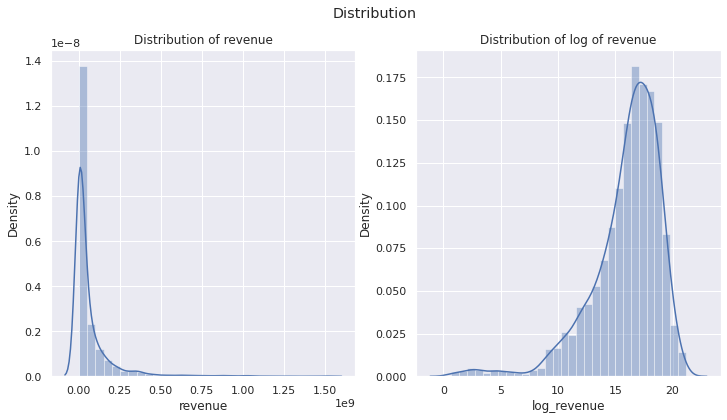

In [224]:
# Distribution of revenue
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
sns.distplot(train['revenue'], bins=30, ax=ax[0])
sns.distplot(train['log_revenue'], bins=30, ax=ax[1])

fig.suptitle('Distribution')
ax[0].title.set_text('Distribution of revenue')
ax[1].title.set_text('Distribution of log of revenue')

revenue distribution has a high skewness it is better to use log of revenue

#### 2.2. belongs_to_collection column <a name="heading--2-2"/>

In [225]:
for i, value in enumerate(train['belongs_to_collection'][:5]):
    print(i, value)

0 [{'id': 313576, 'name': 'Hot Tub Time Machine Collection', 'poster_path': '/iEhb00TGPucF0b4joM1ieyY026U.jpg', 'backdrop_path': '/noeTVcgpBiD48fDjFVic1Vz7ope.jpg'}]
1 [{'id': 107674, 'name': 'The Princess Diaries Collection', 'poster_path': '/wt5AMbxPTS4Kfjx7Fgm149qPfZl.jpg', 'backdrop_path': '/zSEtYD77pKRJlUPx34BJgUG9v1c.jpg'}]
2 {}
3 {}
4 {}


In [226]:
# checking how many rows in 'belongs_to_collection' column is empty
train['belongs_to_collection'].apply(lambda x: len(x) if x != {} else 0).value_counts()


0    2396
1     604
Name: belongs_to_collection, dtype: int64

The most movies do not belong to any collection. Only 604 movies belong to one collection

In [227]:
# list of collection for every movie
collection_names_train = train['belongs_to_collection'].apply(lambda x: [i['name'] for i in x] if x!={} else [])
collection_names_test = test['belongs_to_collection'].apply(lambda x: [i['name'] for i in x] if x!={} else [])

pd.DataFrame({'title': train['title'], 
              'collection': collection_names_train}).head(20)

,title,collection
0,Hot Tub Time Machine 2,[Hot Tub Time Machine Collection]
1,The Princess Diaries 2: Royal Engagement,[The Princess Diaries Collection]
2,Whiplash,[]
3,Kahaani,[]
4,Marine Boy,[]
5,Pinocchio and the Emperor of the Night,[]
6,The Possession,[]
7,Control Room,[]
8,Muppet Treasure Island,[The Muppet Collection]
9,A Mighty Wind,[]


In [228]:
# 25 most frequent collection name without empty values
train['belongs_to_collection'].apply(lambda x: x[0]['name'] if x != {} else 0).value_counts()[1:25]

James Bond Collection                        16
Friday the 13th Collection                    7
The Pink Panther (Original) Collection        6
Pokémon Collection                            5
Police Academy Collection                     5
Rocky Collection                              4
Transformers Collection                       4
Paranormal Activity Collection                4
Alien Collection                              4
The Fast and the Furious Collection           4
Rambo Collection                              4
Ice Age Collection                            4
Resident Evil Collection                      4
Child's Play Collection                       4
Missing in Action Collection                  3
[REC] Collection                              3
Qatsi Collection                              3
Alex Cross Collection                         3
The Vengeance Collection                      3
The Dark Knight Collection                    3
Indiana Jones Collection                

#### 2.3. genres column <a name="heading--2-3"/>

In [229]:
for i, value in enumerate(train['genres'][:5]):
    print(i, value)

0 [{'id': 35, 'name': 'Comedy'}]
1 [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'name': 'Drama'}, {'id': 10751, 'name': 'Family'}, {'id': 10749, 'name': 'Romance'}]
2 [{'id': 18, 'name': 'Drama'}]
3 [{'id': 53, 'name': 'Thriller'}, {'id': 18, 'name': 'Drama'}]
4 [{'id': 28, 'name': 'Action'}, {'id': 53, 'name': 'Thriller'}]


In [230]:
# checking the distribution in genres column
train['genres'].apply(lambda x: len(x) if x != {} else 0).value_counts()

2    972
3    900
1    593
4    393
5    111
6     21
0      7
7      3
Name: genres, dtype: int64

In [231]:
# checking in how many movies there are undefined crew
train['genres'].apply(lambda x: len(x) if x == {} or x == [] else 'defined genres' ).value_counts()

defined genres    2993
0                    7
Name: genres, dtype: int64

There are 7 movies with undefinded genre.

In [232]:
# movies with no genre
pd.DataFrame({'title': train['title'][(train['genres'].apply(lambda x: len(x) if x != {} else 0)) == 0], 
              'genres': train['genres'][(train['genres'].apply(lambda x: len(x) if x != {} else 0)) == 0]})

,title,genres
470,"The Book of Mormon Movie, Volume 1: The Journey",{}
1622,Jackpot,{}
1814,"Ryaba, My Chicken",{}
1819,Sky. Plane. Girl.,{}
2423,Amarkalam,{}
2686,Lift,{}
2900,Rita's Last Fairy Tale,{}


Checking from websites movies with null values in 'genres' train and test sets and adding that genres

- The Book of Mormon Movie, Volume 1: The Journey - https://www.imdb.com/title/tt0349159/ = Adventure
- Jackpot - https://www.imdb.com/title/tt0261755/ = Drama, Comedy
- Ryaba, My Chicken - https://www.imdb.com/title/tt0110289/?ref_=fn_al_tt_1 = Comedy
- Sky. Plane. Girl. - https://www.imdb.com/title/tt0352622/?ref_=nv_sr_srsg_0 = Romance, Drama 
- Amarkalam - https://www.imdb.com/title/tt0984177/?ref_=nv_sr_srsg_0 = Action, Drama, Romance 
- Lift - https://www.imdb.com/title/tt0833448/ = Thriller
- Rita's Last Fairy Tale - https://www.imdb.com/title/tt1766044/ = Drama, Fantasy, Mystery



In [233]:
# adding list of genres to empty cells of genres column - id=0 it isn't important

train.loc[train['genres'].index == 470, 'genres'] \
= train.loc[train['genres'].index == 470, 'genres']\
.apply(lambda x: [{'id': 0, 'name': 'Adventure'}])

train.loc[train['genres'].index == 1622, 'genres'] \
= train.loc[train['genres'].index == 1622, 'genres']\
.apply(lambda x: [{'id': 0, 'name': 'Drama'}, {'id': 0, 'name': 'Comedy'}])

train.loc[train['genres'].index == 1814, 'genres'] \
= train.loc[train['genres'].index == 1814, 'genres']\
.apply(lambda x: [{'id': 0, 'name': 'Comedy'}])

train.loc[train['genres'].index == 1819, 'genres'] \
= train.loc[train['genres'].index == 1819, 'genres']\
.apply(lambda x: [{'id': 0, 'name': 'Romance'}, {'id': 0, 'name': 'Drama'}])

train.loc[train['genres'].index == 2423, 'genres'] \
= train.loc[train['genres'].index == 2423, 'genres']\
.apply(lambda x: [{'id': 0, 'name': 'Action'}, {'id': 0, 'name': 'Drama'}, {'id': 0, 'name': 'Romance'}])

train.loc[train['genres'].index == 2686, 'genres'] \
= train.loc[train['genres'].index == 2686, 'genres']\
.apply(lambda x: [{'id': 0, 'name': 'Thriller'}])

train.loc[train['genres'].index == 2900, 'genres'] \
= train.loc[train['genres'].index == 2900, 'genres']\
.apply(lambda x: [{'id': 0, 'name': 'Drama'}, {'id': 0, 'name': 'Fantasy'}, {'id': 0, 'name': 'Mystery'}])

train[['title', 'release_date', 'genres']][(train['genres'].index == 470) \
                                           | (train['genres'].index == 1622) \
                                           | (train['genres'].index == 1814) \
                                           | (train['genres'].index == 1819) \
                                           | (train['genres'].index == 2423) \
                                           | (train['genres'].index == 2686) \
                                           | (train['genres'].index == 2900)]

,title,release_date,genres
470,"The Book of Mormon Movie, Volume 1: The Journey",9/12/03,"[{'id': 0, 'name': 'Adventure'}]"
1622,Jackpot,7/26/01,"[{'id': 0, 'name': 'Drama'}, {'id': 0, 'name':..."
1814,"Ryaba, My Chicken",10/1/94,"[{'id': 0, 'name': 'Comedy'}]"
1819,Sky. Plane. Girl.,9/2/02,"[{'id': 0, 'name': 'Romance'}, {'id': 0, 'name..."
2423,Amarkalam,8/25/99,"[{'id': 0, 'name': 'Action'}, {'id': 0, 'name'..."
2686,Lift,7/1/06,"[{'id': 0, 'name': 'Thriller'}]"
2900,Rita's Last Fairy Tale,11/1/12,"[{'id': 0, 'name': 'Drama'}, {'id': 0, 'name':..."


In [234]:
# checking if there still are movies with no genre
train['genres'][(train['genres'].apply(lambda x: len(x) if x != {} else 0)) == 0]

Series([], Name: genres, dtype: object)

In [235]:
# list of genres for every movie
genres_names_train = train['genres'].apply(lambda x: [i['name'] for i in x] if x!={} else [])
genres_names_test = test['genres'].apply(lambda x: [i['name'] for i in x] if x!={} else [])

pd.DataFrame({'title': train['title'], 
              'genres': genres_names_train,
              'genres_number': genres_names_train.apply(len)}).head(20)

,title,genres,genres_number
0,Hot Tub Time Machine 2,[Comedy],1
1,The Princess Diaries 2: Royal Engagement,"[Comedy, Drama, Family, Romance]",4
2,Whiplash,[Drama],1
3,Kahaani,"[Thriller, Drama]",2
4,Marine Boy,"[Action, Thriller]",2
5,Pinocchio and the Emperor of the Night,"[Animation, Adventure, Family]",3
6,The Possession,"[Horror, Thriller]",2
7,Control Room,[Documentary],1
8,Muppet Treasure Island,"[Action, Comedy, Music, Family, Adventure]",5
9,A Mighty Wind,"[Comedy, Music]",2


unique value of genres in train set

In [236]:
train_li = []
[train_li.append(dic['name']) for li in train['genres'] for dic in li if dic['name'] not in train_li]
sorted(train_li)

['Action',
 'Adventure',
 'Animation',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'Foreign',
 'History',
 'Horror',
 'Music',
 'Mystery',
 'Romance',
 'Science Fiction',
 'TV Movie',
 'Thriller',
 'War',
 'Western']

unique value of genres in test set

In [237]:
test_li = []
[test_li.append(dic['name']) for li in test['genres'] for dic in li if dic['name'] not in test_li]
sorted(test_li)

['Action',
 'Adventure',
 'Animation',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'Foreign',
 'History',
 'Horror',
 'Music',
 'Mystery',
 'Romance',
 'Science Fiction',
 'Thriller',
 'War',
 'Western']

Most common genres. Some movies have no genre, some has only one and other have more than one

In [238]:
# The most common genres
genres_count = Counter([i for j in genres_names_train for i in j]).most_common()
genres_count

[('Drama', 1535),
 ('Comedy', 1030),
 ('Thriller', 790),
 ('Action', 742),
 ('Romance', 573),
 ('Crime', 469),
 ('Adventure', 440),
 ('Horror', 301),
 ('Science Fiction', 290),
 ('Family', 260),
 ('Fantasy', 233),
 ('Mystery', 226),
 ('Animation', 141),
 ('History', 132),
 ('Music', 100),
 ('War', 100),
 ('Documentary', 87),
 ('Western', 43),
 ('Foreign', 31),
 ('TV Movie', 1)]

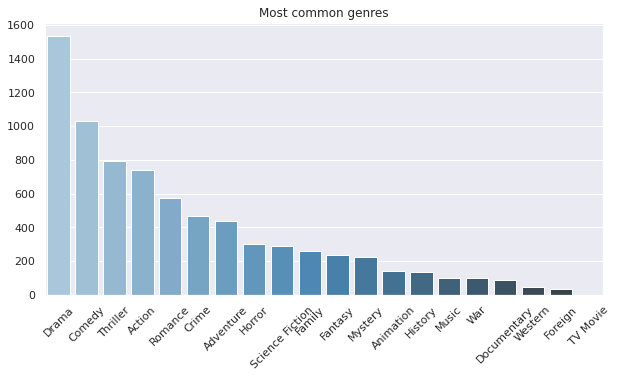

In [239]:
# The most common genres - plot
fig = plt.figure(figsize=(10, 5))
sns.barplot(y=[value[1] for value in genres_count],
            x=[value[0] for value in genres_count],
            palette="Blues_d")
plt.title('Most common genres')
plt.xticks(rotation=45)
plt.show()

#### 2.4. production_companies column <a name="heading--2-4"/>

In [240]:
for i, value in enumerate(train['production_companies'][:5]):
    print(i, value)

0 [{'name': 'Paramount Pictures', 'id': 4}, {'name': 'United Artists', 'id': 60}, {'name': 'Metro-Goldwyn-Mayer (MGM)', 'id': 8411}]
1 [{'name': 'Walt Disney Pictures', 'id': 2}]
2 [{'name': 'Bold Films', 'id': 2266}, {'name': 'Blumhouse Productions', 'id': 3172}, {'name': 'Right of Way Films', 'id': 32157}]
3 {}
4 {}


In [241]:
# checking the distribution in 'production_companies' column
train['production_companies'].apply(lambda x: len(x) if x != {} else 0).value_counts()

1     775
2     734
3     582
4     312
5     166
0     156
6     118
7      62
8      42
9      29
11      7
10      7
12      3
16      2
15      2
14      1
13      1
17      1
Name: production_companies, dtype: int64

The most movies were created by one or to 9 production companies

In [242]:
# list of production companies for every movie
prod_companies_names_train = train['production_companies'].apply(lambda x: [i['name'] for i in x] if x!={} else [])
prod_companies_names_test = test['production_companies'].apply(lambda x: [i['name'] for i in x] if x!={} else [])

pd.DataFrame({'title': train['title'], 
              'production_companies': prod_companies_names_train,
              'production_companies_number': prod_companies_names_train.apply(len)}).head(20)

,title,production_companies,production_companies_number
0,Hot Tub Time Machine 2,"[Paramount Pictures, United Artists, Metro-Gol...",3
1,The Princess Diaries 2: Royal Engagement,[Walt Disney Pictures],1
2,Whiplash,"[Bold Films, Blumhouse Productions, Right of W...",3
3,Kahaani,[],0
4,Marine Boy,[],0
5,Pinocchio and the Emperor of the Night,[],0
6,The Possession,"[Ghost House Pictures, North Box Productions]",2
7,Control Room,[],0
8,Muppet Treasure Island,"[Walt Disney Pictures, Jim Henson Productions,...",3
9,A Mighty Wind,[Castle Rock Entertainment],1


In [243]:
# 20 most common production companies
production_companies_count = Counter([i for j in prod_companies_names_train for i in j]).most_common()
production_companies_count[:20]

[('Warner Bros.', 202),
 ('Universal Pictures', 188),
 ('Paramount Pictures', 161),
 ('Twentieth Century Fox Film Corporation', 138),
 ('Columbia Pictures', 91),
 ('Metro-Goldwyn-Mayer (MGM)', 84),
 ('New Line Cinema', 75),
 ('Touchstone Pictures', 63),
 ('Walt Disney Pictures', 62),
 ('Columbia Pictures Corporation', 61),
 ('TriStar Pictures', 53),
 ('Relativity Media', 48),
 ('Canal+', 46),
 ('United Artists', 44),
 ('Miramax Films', 40),
 ('Village Roadshow Pictures', 36),
 ('Regency Enterprises', 31),
 ('BBC Films', 30),
 ('Dune Entertainment', 30),
 ('Working Title Films', 30)]

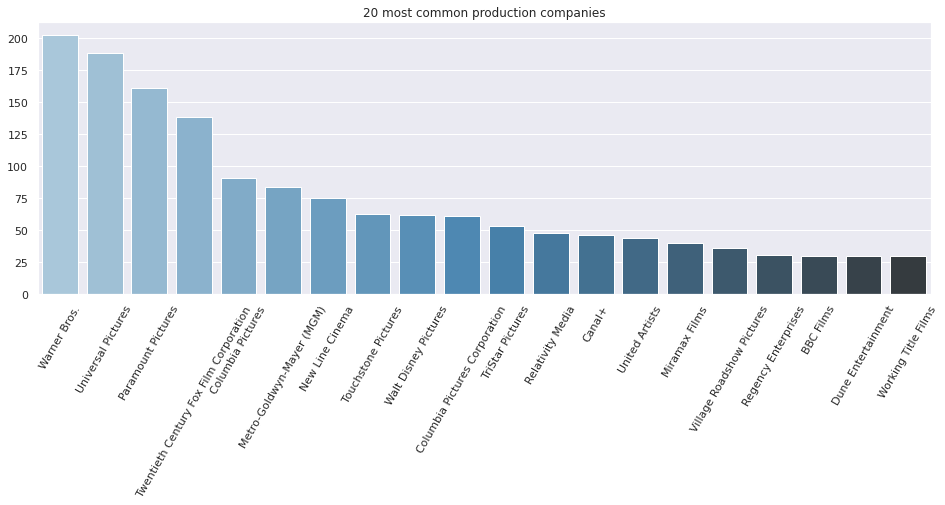

In [244]:
# 20 most common production companies - plot
fig = plt.figure(figsize=(16, 5))
sns.barplot(y=[value[1] for value in production_companies_count[:20]],
            x=[value[0] for value in production_companies_count[:20]],
            palette="Blues_d")
plt.title('20 most common production companies')
plt.xticks(rotation=60)
plt.show()

#### 2.5. production_countries column <a name="heading--2-5"/>

In [245]:
for i, value in enumerate(train['production_countries'][:5]):
    print(i, value)

0 [{'iso_3166_1': 'US', 'name': 'United States of America'}]
1 [{'iso_3166_1': 'US', 'name': 'United States of America'}]
2 [{'iso_3166_1': 'US', 'name': 'United States of America'}]
3 [{'iso_3166_1': 'IN', 'name': 'India'}]
4 [{'iso_3166_1': 'KR', 'name': 'South Korea'}]


In [246]:
# checking the distribution in 'production_countries' column
train['production_countries'].apply(lambda x: len(x) if x != {} else 0).value_counts()

1    2222
2     525
3     116
4      57
0      55
5      21
6       3
8       1
Name: production_countries, dtype: int64

We can see that one production coutry is the most common and later 2 countries. There are also 55 movies with no production coutry

In [247]:
# 10 sample movies with no production country
pd.DataFrame({'title': train['title'][(train['production_countries'].apply(lambda x: len(x) if x != {} else 0)) == 0], 
              'production_countries': train['production_countries'][(train['genres'].apply(lambda x: len(x) if x != {} else 0)) == 0]}).head(10)

,title,production_countries
5,Pinocchio and the Emperor of the Night,NaN
7,Control Room,NaN
38,Final: The Rapture,NaN
259,The Terrorist,NaN
269,Glass: A Portrait of Philip in Twelve Parts,NaN
445,Tapeheads,NaN
457,Swoon,NaN
470,"The Book of Mormon Movie, Volume 1: The Journey",NaN
498,Lake of Fire,NaN
609,The Swan Princess: Escape from Castle Mountain,NaN


In [248]:
# list of production countries for every movie
prod_countries_names_train = train['production_countries'].apply(lambda x: [i['name'] for i in x] if x!={} else [])
prod_countries_names_test = test['production_countries'].apply(lambda x: [i['name'] for i in x] if x!={} else [])

pd.DataFrame({'title': train['title'], 
              'production_countries': prod_countries_names_train,
              'production_countries_number': prod_countries_names_train.apply(len)}).head(20)

,title,production_countries,production_countries_number
0,Hot Tub Time Machine 2,[United States of America],1
1,The Princess Diaries 2: Royal Engagement,[United States of America],1
2,Whiplash,[United States of America],1
3,Kahaani,[India],1
4,Marine Boy,[South Korea],1
5,Pinocchio and the Emperor of the Night,[],0
6,The Possession,"[United States of America, Canada]",2
7,Control Room,[],0
8,Muppet Treasure Island,[United States of America],1
9,A Mighty Wind,[United States of America],1


In [249]:
# 20 most common production countries
production_countries_count = Counter([i for j in prod_countries_names_train for i in j]).most_common()
production_countries_count[:20]

[('United States of America', 2282),
 ('United Kingdom', 380),
 ('France', 222),
 ('Germany', 167),
 ('Canada', 120),
 ('India', 81),
 ('Italy', 64),
 ('Japan', 61),
 ('Australia', 61),
 ('Russia', 58),
 ('Spain', 54),
 ('China', 42),
 ('Hong Kong', 42),
 ('Ireland', 23),
 ('Belgium', 23),
 ('South Korea', 22),
 ('Mexico', 19),
 ('Sweden', 18),
 ('New Zealand', 17),
 ('Netherlands', 15)]

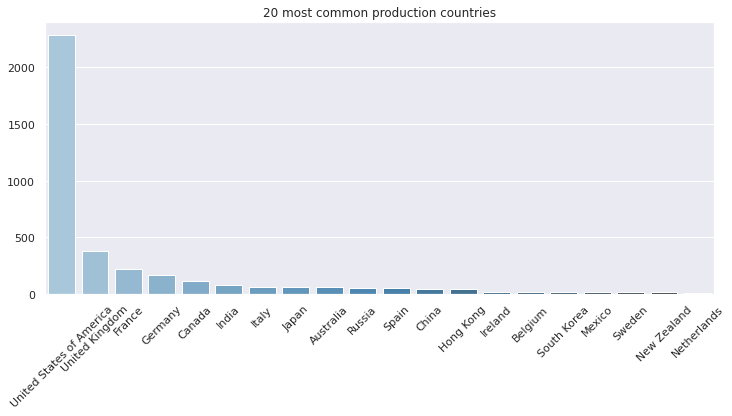

In [250]:
# 20 most common production countries - plot
fig = plt.figure(figsize=(12, 5))
sns.barplot(y=[value[1] for value in production_countries_count[:20]],
            x=[value[0] for value in production_countries_count[:20]],
            palette="Blues_d")
plt.title('20 most common production countries')
plt.xticks(rotation=45)
plt.show()

#### 2.6. spoken_languages column <a name="heading--2-6"/>

In [251]:
for i, value in enumerate(train['spoken_languages'][:5]):
    print(i, value)

0 [{'iso_639_1': 'en', 'name': 'English'}]
1 [{'iso_639_1': 'en', 'name': 'English'}]
2 [{'iso_639_1': 'en', 'name': 'English'}]
3 [{'iso_639_1': 'en', 'name': 'English'}, {'iso_639_1': 'hi', 'name': 'हिन्दी'}]
4 [{'iso_639_1': 'ko', 'name': '한국어/조선말'}]


In [252]:
# checking the distribution in 'spoken_languages' column
train['spoken_languages'].apply(lambda x: len(x) if x != {} else 0).value_counts()

1    2105
2     549
3     216
4      72
5      23
0      20
7       6
6       6
8       2
9       1
Name: spoken_languages, dtype: int64

We can see that the most movies have one spoken language later 2. There are also 20 movies with undefined spoken language but in original language we have that information.

In [253]:
# movies with no spoken language
pd.DataFrame({'title': train['title'][(train['spoken_languages'].apply(lambda x: len(x) if x != {} else 0)) == 0], 
              'spoken_languages': train['spoken_languages'][(train['spoken_languages'].apply(lambda x: len(x) if x != {} else 0)) == 0],
              'original_language': train['original_language'][(train['spoken_languages'].apply(lambda x: len(x) if x != {} else 0)) == 0]})

,title,spoken_languages,original_language
150,Windwalker,{},en
177,Boys Life 2,{},en
454,Sweet Hearts Dance,{},en
470,"The Book of Mormon Movie, Volume 1: The Journey",{},en
979,Russkies,{},en
1101,Crazy Love,{},en
1333,One Bright Shining Moment,{},en
1335,Королёв,{},ru
1483,The Wedding Ringer,{},en
1503,Campus Man,{},en


In [254]:
# list of spoken languages for every movie
spoken_languages_names_train = train['spoken_languages'].apply(lambda x: [i['name'] for i in x] if x!={} else [])
spoken_languages_names_test = test['spoken_languages'].apply(lambda x: [i['name'] for i in x] if x!={} else [])

pd.DataFrame({'title': train['title'], 
              'languages': spoken_languages_names_train,
              'languages_number': spoken_languages_names_train.apply(len)}).head(20)

,title,languages,languages_number
0,Hot Tub Time Machine 2,[English],1
1,The Princess Diaries 2: Royal Engagement,[English],1
2,Whiplash,[English],1
3,Kahaani,"[English, हिन्दी]",2
4,Marine Boy,[한국어/조선말],1
5,Pinocchio and the Emperor of the Night,[English],1
6,The Possession,[English],1
7,Control Room,"[العربية, English]",2
8,Muppet Treasure Island,[English],1
9,A Mighty Wind,[English],1


In [255]:
# 20 most common spoken languages
spoken_languages_count = Counter([i for j in spoken_languages_names_train for i in j]).most_common()
spoken_languages_count[:20]

[('English', 2618),
 ('Français', 288),
 ('Español', 239),
 ('Deutsch', 169),
 ('Pусский', 152),
 ('Italiano', 124),
 ('日本語', 89),
 ('普通话', 68),
 ('हिन्दी', 56),
 ('', 47),
 ('Português', 43),
 ('العربية', 40),
 ('한국어/조선말', 37),
 ('广州话 / 廣州話', 36),
 ('தமிழ்', 27),
 ('Polski', 25),
 ('Magyar', 24),
 ('Latin', 23),
 ('svenska', 22),
 ('ภาษาไทย', 22)]

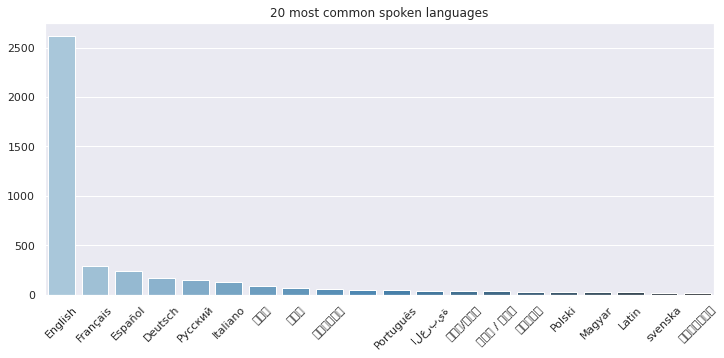

In [256]:
# 20 most common spoken languages - plot
fig = plt.figure(figsize=(12, 5))
sns.barplot(y=[value[1] for value in spoken_languages_count[:20]],
            x=[value[0] for value in spoken_languages_count[:20]],
            palette="Blues_d")
plt.title('20 most common spoken languages')
plt.xticks(rotation=45)
plt.show()

#### 2.7. Keywords column <a name="heading--2-7"/>

In [257]:
for i, value in enumerate(train['Keywords'][:5]):
    print(i, value)

0 [{'id': 4379, 'name': 'time travel'}, {'id': 9663, 'name': 'sequel'}, {'id': 11830, 'name': 'hot tub'}, {'id': 179431, 'name': 'duringcreditsstinger'}]
1 [{'id': 2505, 'name': 'coronation'}, {'id': 4263, 'name': 'duty'}, {'id': 6038, 'name': 'marriage'}, {'id': 13072, 'name': 'falling in love'}]
2 [{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'name': 'obsession'}, {'id': 1640, 'name': 'conservatory'}, {'id': 2176, 'name': 'music teacher'}, {'id': 14512, 'name': 'new york city'}, {'id': 14819, 'name': 'violence'}, {'id': 33896, 'name': 'montage'}, {'id': 156823, 'name': 'drummer'}, {'id': 170418, 'name': 'public humiliation'}, {'id': 176095, 'name': 'jazz band'}, {'id': 206298, 'name': 'young adult'}, {'id': 207739, 'name': 'music school'}]
3 [{'id': 10092, 'name': 'mystery'}, {'id': 10540, 'name': 'bollywood'}, {'id': 11734, 'name': 'police corruption'}, {'id': 14536, 'name': 'crime'}, {'id': 14636, 'name': 'india'}, {'id': 208364, 'name': 'missing husband'}, {'id': 220935, 'name': 'ne

In [258]:
# checking the distribution in 'Keywords' column
train['Keywords'].apply(lambda x: len(x) if x != {} else 0).value_counts()

5      293
0      276
4      248
3      228
6      227
2      207
7      192
1      187
8      161
9      134
11     132
10     125
12     100
13      85
14      59
15      59
16      58
17      45
18      29
20      24
21      23
19      22
22      17
23      15
24      12
27      12
25       6
26       5
32       2
28       2
30       2
31       2
29       2
37       2
43       1
40       1
38       1
33       1
97       1
39       1
149      1
Name: Keywords, dtype: int64

Every movie has a very different number of Keywords. 276 movies do not have any one.

In [259]:
# list of Keywords for every movie
keywords_names_train = train['Keywords'].apply(lambda x: [i['name'] for i in x] if x!={} else [])
keywords_names_test = test['Keywords'].apply(lambda x: [i['name'] for i in x] if x!={} else [])

pd.DataFrame({'title': train['title'], 
              'Keywords': keywords_names_train,
              'Keywords_number': keywords_names_train.apply(len)}).head(20)

,title,Keywords,Keywords_number
0,Hot Tub Time Machine 2,"[time travel, sequel, hot tub, duringcreditsst...",4
1,The Princess Diaries 2: Royal Engagement,"[coronation, duty, marriage, falling in love]",4
2,Whiplash,"[jazz, obsession, conservatory, music teacher,...",12
3,Kahaani,"[mystery, bollywood, police corruption, crime,...",7
4,Marine Boy,[],0
5,Pinocchio and the Emperor of the Night,[],0
6,The Possession,[],0
7,Control Room,"[journalism, translation, television, manipula...",7
8,Muppet Treasure Island,"[island, pirate gang, puppet, treasure hunt]",4
9,A Mighty Wind,"[mockumentary, folk singer]",2


In [260]:
# 20 most common Keywords
keywords_count = Counter([i for j in keywords_names_train for i in j]).most_common()
keywords_count[:20]

[('woman director', 175),
 ('independent film', 155),
 ('duringcreditsstinger', 134),
 ('murder', 123),
 ('based on novel', 111),
 ('violence', 87),
 ('sport', 82),
 ('biography', 77),
 ('aftercreditsstinger', 75),
 ('dystopia', 73),
 ('revenge', 73),
 ('friendship', 72),
 ('sex', 71),
 ('suspense', 67),
 ('sequel', 66),
 ('love', 64),
 ('police', 64),
 ('teenager', 61),
 ('nudity', 57),
 ('female nudity', 53)]

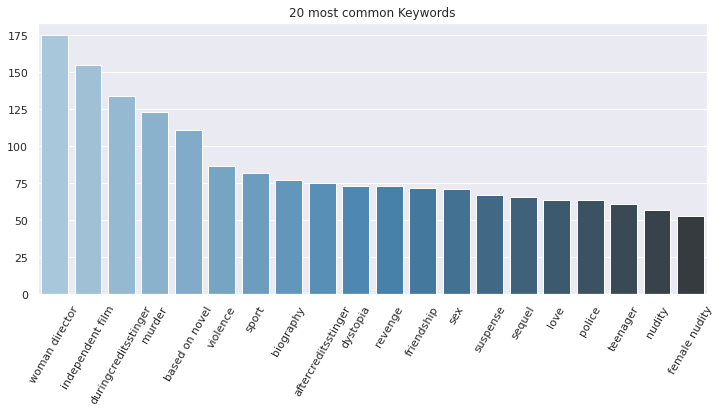

In [261]:
# 20 most common Keywords - plot
fig = plt.figure(figsize=(12, 5))
sns.barplot(y=[value[1] for value in keywords_count[:20]],
            x=[value[0] for value in keywords_count[:20]],
            palette="Blues_d")
plt.title('20 most common Keywords')
plt.xticks(rotation=60)
plt.show()

#### 2.8. cast column <a name="heading--2-8"/>

In [262]:
train['cast'][0][:2]


[{'cast_id': 4,
  'character': 'Lou',
  'credit_id': '52fe4ee7c3a36847f82afae7',
  'gender': 2,
  'id': 52997,
  'name': 'Rob Corddry',
  'order': 0,
  'profile_path': '/k2zJL0V1nEZuFT08xUdOd3ucfXz.jpg'},
 {'cast_id': 5,
  'character': 'Nick',
  'credit_id': '52fe4ee7c3a36847f82afaeb',
  'gender': 2,
  'id': 64342,
  'name': 'Craig Robinson',
  'order': 1,
  'profile_path': '/tVaRMkJXOEVhYxtnnFuhqW0Rjzz.jpg'}]

In [263]:
# checking the distribution in 'cast' column
train['cast'].apply(lambda x: len(x) if x != {} else 0).value_counts()

15     212
16     165
10     135
13     129
12     124
      ... 
90       1
88       1
84       1
82       1
134      1
Name: cast, Length: 109, dtype: int64

In [264]:
# checking in how many movies there are undefined cast
train['cast'].apply(lambda x: len(x) if x == {} or x == [] else 'defined actors' ).value_counts()

defined actors    2974
0                   26
Name: cast, dtype: int64

There are 26 movies with undefinded actors.

In [265]:
# movies with no actors
pd.DataFrame({'title': train['title'][(train['cast'].apply(lambda x: len(x) if x != {} else 0)) == 0], 
              'cast': train['cast'][(train['cast'].apply(lambda x: len(x) if x != {} else 0)) == 0]})

,title,cast
233,Sweetgrass,[]
518,Wonder Woman,{}
680,The Day After Tomorrow,{}
773,Live Nude Girls Unite!,[]
906,The Dark Knight Rises,{}
934,John Wick: Chapter 2,{}
1136,Pokémon: Arceus and the Jewel of Life,[]
1303,Mr. Smith Goes to Washington,{}
1617,The Assassination of Richard Nixon,{}
1777,Naqoyqatsi,[]


In [266]:
# list of cast/actors for every movie
cast_names_train = train['cast'].apply(lambda x: [i['name'] for i in x] if x!={} else [])

pd.DataFrame({'title': train['title'], 
              'actors': cast_names_train,
              'actors_number': cast_names_train.apply(len),
              'unassigned_cast_gender': train['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 0])),
              'actresses_num': train['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 1])),
              'actors_num': train['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))}).head(20)

,title,actors,actors_number,unassigned_cast_gender,actresses_num,actors_num
0,Hot Tub Time Machine 2,"[Rob Corddry, Craig Robinson, Clark Duke, Adam...",24,6,8,10
1,The Princess Diaries 2: Royal Engagement,"[Anne Hathaway, Julie Andrews, H√©ctor Elizond...",20,0,10,10
2,Whiplash,"[Miles Teller, J.K. Simmons, Melissa Benoist, ...",51,31,7,13
3,Kahaani,"[Vidya Balan, Nawazuddin Siddiqui, Parambrata ...",7,4,1,2
4,Marine Boy,"[Kim Kang-woo, Jo Jae-hyeon, Park Si-yeon, Kim...",4,0,0,4
5,Pinocchio and the Emperor of the Night,"[Scott Grimes, Tom Bosley, Rickie Lee Jones, J...",4,2,0,2
6,The Possession,"[Jeffrey Dean Morgan, Natasha Calis, Madison D...",14,4,3,7
7,Control Room,"[Samir Khader, Josh Rushing, George W. Bush, H...",4,3,0,1
8,Muppet Treasure Island,"[Tim Curry, Kevin Bishop, Jennifer Saunders, B...",12,5,1,6
9,A Mighty Wind,"[Bob Balaban, Christopher Guest, John Michael ...",20,2,5,13


In [267]:
# 20 most common actors
cast_count = Counter([i for j in cast_names_train for i in j]).most_common()
cast_count[:20]

[('Samuel L. Jackson', 30),
 ('Robert De Niro', 30),
 ('Morgan Freeman', 27),
 ('J.K. Simmons', 25),
 ('Bruce Willis', 25),
 ('Liam Neeson', 25),
 ('Susan Sarandon', 25),
 ('Bruce McGill', 24),
 ('John Turturro', 24),
 ('Forest Whitaker', 23),
 ('Willem Dafoe', 23),
 ('Bill Murray', 22),
 ('Owen Wilson', 22),
 ('Nicolas Cage', 22),
 ('Sylvester Stallone', 21),
 ('Jason Statham', 21),
 ('Keith David', 21),
 ('John Goodman', 21),
 ('Mel Gibson', 21),
 ('Sigourney Weaver', 21)]

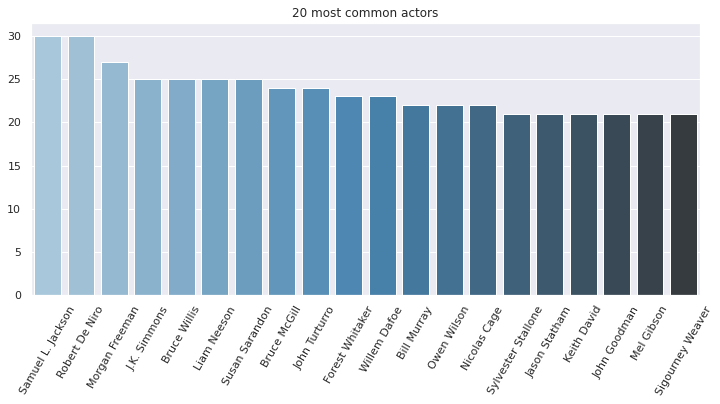

In [268]:
# 20 most common actors - plot
fig = plt.figure(figsize=(12, 5))
sns.barplot(y=[value[1] for value in cast_count[:20]],
            x=[value[0] for value in cast_count[:20]],
            palette="Blues_d")
plt.title('20 most common actors')
plt.xticks(rotation=60)
plt.show()

#### 2.9. crew column <a name="heading--2-9"/>

In [269]:
train['crew'][0][:2]

[{'credit_id': '59ac067c92514107af02c8c8',
  'department': 'Directing',
  'gender': 0,
  'id': 1449071,
  'job': 'First Assistant Director',
  'name': 'Kelly Cantley',
  'profile_path': None},
 {'credit_id': '52fe4ee7c3a36847f82afad7',
  'department': 'Directing',
  'gender': 2,
  'id': 3227,
  'job': 'Director',
  'name': 'Steve Pink',
  'profile_path': '/myHOgo8mQSCiCAZNGMRdHVr03jr.jpg'}]

In [270]:
# checking the distribution in 'crew' column
train['crew'].apply(lambda x: len(x) if x != {} else 0).value_counts()

2      179
11     127
10     126
3      126
12     110
      ... 
126      1
122      1
98       1
96       1
183      1
Name: crew, Length: 153, dtype: int64

In [271]:
# checking in how many movies there are undefined crew
train['crew'].apply(lambda x: len(x) if x == {} or x == [] else 'defined crew' ).value_counts()

defined crew    2984
0                 16
Name: crew, dtype: int64

There are 16 movies with undefinded crew.

In [272]:
# movies with no crew
pd.DataFrame({'title': train['title'][(train['crew'].apply(lambda x: len(x) if x != {} else 0)) == 0], 
              'crew': train['crew'][(train['crew'].apply(lambda x: len(x) if x != {} else 0)) == 0]})

,title,crew
470,"The Book of Mormon Movie, Volume 1: The Journey",{}
518,Wonder Woman,{}
680,The Day After Tomorrow,{}
906,The Dark Knight Rises,{}
934,John Wick: Chapter 2,{}
1303,Mr. Smith Goes to Washington,{}
1617,The Assassination of Richard Nixon,{}
1783,Logan,{}
2014,The Wolf of Wall Street,{}
2302,Happy Weekend,{}


In [273]:
# list of crew for every movie
crew_names_train = train['crew'].apply(lambda x: [i['name'] for i in x] if x!={} else [])

pd.DataFrame({'title': train['title'], 
              'crew': crew_names_train,
              'crew_number': crew_names_train.apply(len),
              'unassigned_crew_gender': train['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 0])),
              'female_crew': train['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 1])),
              'male_crew': train['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))}).head(20)

,title,crew,crew_number,unassigned_crew_gender,female_crew,male_crew
0,Hot Tub Time Machine 2,"[Kelly Cantley, Steve Pink, Josh Heald, Josh H...",72,59,0,13
1,The Princess Diaries 2: Royal Engagement,"[Garry Marshall, Charles Minsky, John Debney, ...",9,1,4,4
2,Whiplash,"[Terri Taylor, Richard Henderson, Jeffrey Stot...",64,49,4,11
3,Kahaani,"[Sujoy Ghosh, Sujoy Ghosh, Sujoy Ghosh]",3,3,0,0
4,Marine Boy,"[Jong-seok Yoon, Jong-seok Yoon]",2,2,0,0
5,Pinocchio and the Emperor of the Night,"[Collodi, Hal Sutherland, Dennis O'Flaherty, B...",11,7,0,4
6,The Possession,"[Sam Raimi, Nancy Nayor, Anders Villadsen, Eri...",77,60,6,11
7,Control Room,[Jehane Noujaim],1,0,1,0
8,Muppet Treasure Island,"[Brian Henson, Frank Oz, Brian Henson, Jerry J...",8,1,0,7
9,A Mighty Wind,"[Christopher Guest, Christopher Guest, Eugene ...",11,3,4,4


In [274]:
# gender of the crew - Male 2, Female 1 and 0 is Unassigned
list_of_crew_genders = list(train['crew'].apply(lambda x: [i['gender'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_crew_genders for i in j]).most_common(3)

[(0, 41787), (2, 24898), (1, 6412)]

In [275]:
# 20 most common crew members
crew_count = Counter([i for j in crew_names_train for i in j]).most_common()
crew_count[:20]

[('Avy Kaufman', 50),
 ('Robert Rodriguez', 44),
 ('Deborah Aquila', 40),
 ('James Newton Howard', 39),
 ('Mary Vernieu', 38),
 ('Steven Spielberg', 37),
 ('Luc Besson', 37),
 ('Jerry Goldsmith', 37),
 ('Francine Maisler', 35),
 ('Tricia Wood', 35),
 ('James Horner', 33),
 ('Kerry Barden', 32),
 ('Bob Weinstein', 30),
 ('Harvey Weinstein', 30),
 ('Janet Hirshenson', 30),
 ('Jane Jenkins', 29),
 ('John Debney', 28),
 ('Hans Zimmer', 28),
 ('John Papsidera', 28),
 ('Francis Ford Coppola', 28)]

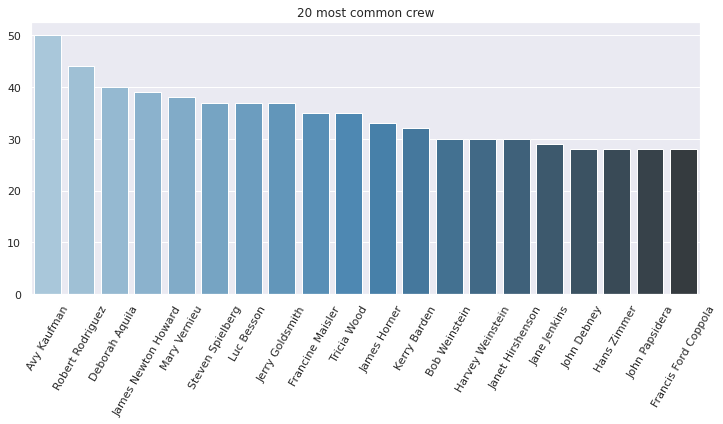

In [276]:
# 20 most common crew members - plot
fig = plt.figure(figsize=(12, 5))
sns.barplot(y=[value[1] for value in crew_count[:20]],
            x=[value[0] for value in crew_count[:20]],
            palette="Blues_d")
plt.title('20 most common crew')
plt.xticks(rotation=60)
plt.show()

#### 2.10. homepage column <a name="heading--2-10"/>

In [277]:
train['homepage'][:5]

0                                  NaN
1                                  NaN
2    http://sonyclassics.com/whiplash/
3           http://kahaanithefilm.com/
4                                  NaN
Name: homepage, dtype: object

In [278]:
# chcecking how many null values in homepage column are
train['homepage'].isna().value_counts()

True     2054
False     946
Name: homepage, dtype: int64

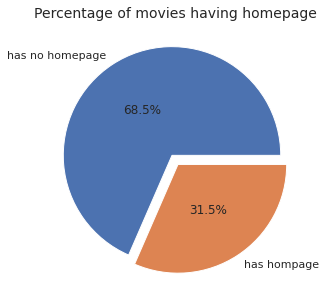

In [279]:
plt.figure(figsize=(5,5))
plt.pie(x=train['homepage'].isna().value_counts(), autopct="%.1f%%", 
        explode=[0.05]*2, labels=['has no homepage', 'has hompage'], 
        pctdistance=0.5)
plt.title("Percentage of movies having homepage", fontsize=14)
plt.show()

In [280]:
train['homepage'].value_counts()[:10]

http://www.transformersmovie.com/                                     4
http://www.lordoftherings.net/                                        2
http://www.thehobbit.com/                                             2
http://dragontattoofilm.com/about-5/the-girl-who-played-with-fire/    1
http://disney.go.com/disneypictures/the-odd-life-of-timothy-green/    1
http://www.thespiritofvengeance.com/                                  1
http://www.childrenofhuangshi.com/                                    1
http://www.redridinghoodmovie.com/                                    1
http://hardcandymovie.com/                                            1
http://www.call-movie.com/                                            1
Name: homepage, dtype: int64

link to homepage is not useful. The information which is important is a movie has a homepage or not. Let's check if there is a relation between a movie has a homepage or not and revenue 

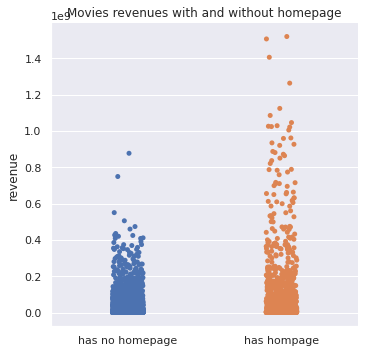

In [281]:
sns.catplot(data=train, x=np.where(train['homepage'].isna(), 0, 1), y='revenue')\
.set_xticklabels(['has no homepage', 'has hompage'])
plt.title('Movies revenues with and without homepage')
plt.show()

Movies with homepage can generate more revenue

#### 2.11. imdb_id column <a name="heading--2-11"/>

In [282]:
train['imdb_id'][:10]

0    tt2637294
1    tt0368933
2    tt2582802
3    tt1821480
4    tt1380152
5    tt0093743
6    tt0431021
7    tt0391024
8    tt0117110
9    tt0310281
Name: imdb_id, dtype: object

In [283]:
# chcecking how many null values in imdb_id column are
train['imdb_id'].isna().value_counts()

False    3000
Name: imdb_id, dtype: int64

In [284]:
train['imdb_id'].value_counts()[:5]

tt1216487    1
tt0338094    1
tt1911658    1
tt0815244    1
tt0121766    1
Name: imdb_id, dtype: int64

Every imdb_id is unique and it is useless for modeling. It will be deleted.

#### 2.12. original_language column <a name="heading--2-12"/>

In [285]:
train['original_language'][:10]

0    en
1    en
2    en
3    hi
4    ko
5    en
6    en
7    en
8    en
9    en
Name: original_language, dtype: object

In [286]:
# chcecking how many null values in original_language column are
train['original_language'].isna().value_counts()

False    3000
Name: original_language, dtype: int64

In [287]:
train['original_language'].value_counts()[:20]

en    2575
fr      78
ru      47
es      43
hi      42
ja      37
it      24
cn      20
ko      20
zh      19
de      18
ta      16
sv       8
pt       6
nl       6
fa       5
da       5
ro       4
hu       3
tr       3
Name: original_language, dtype: int64

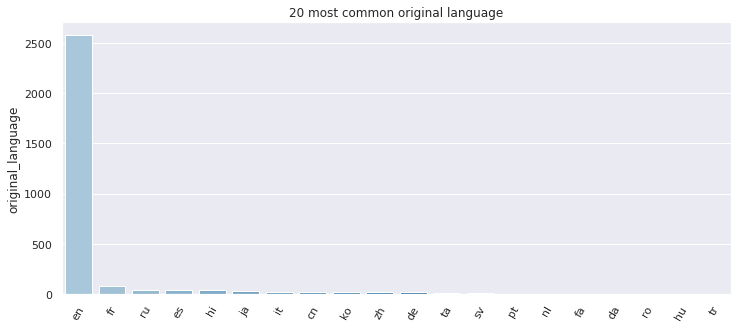

In [288]:
# 20 most common original language - plot
fig = plt.figure(figsize=(12, 5))
sns.barplot(y=train['original_language'].value_counts()[:20],
            x=train['original_language'].value_counts()[:20].index,
            palette="Blues_d")
plt.title('20 most common original language')
plt.xticks(rotation=60)
plt.show()

English is the most common original language in movies. 

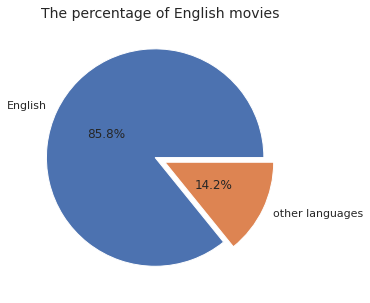

In [289]:
plt.figure(figsize=(5,5))
plt.pie(x=(train['original_language'] == 'en').value_counts(), autopct="%.1f%%", 
        explode=[0.05]*2, labels=['English', 'other languages'], 
        pctdistance=0.5)
plt.title("The percentage of English movies", fontsize=14)
plt.show()

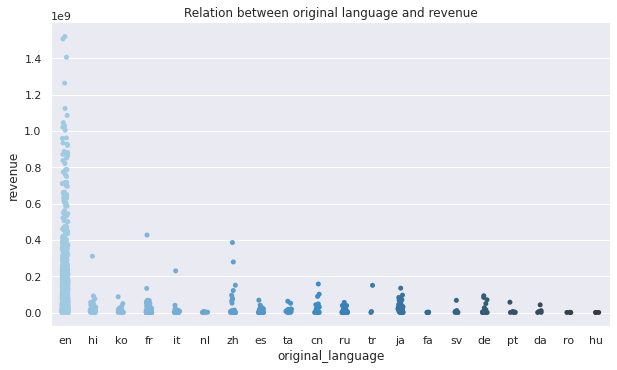

In [290]:
# Relation between original language and revenue
sns.catplot(data=train.loc[train['original_language'].isin(train['original_language'].value_counts().head(20).index)], 
            x='original_language', y='revenue', height=5, aspect=1.7, palette="Blues_d")
plt.title('Relation between original language and revenue')
plt.show()

#### 2.13. original_title column <a name="heading--2-13"/>

In [291]:
train['original_title'][:10]

0                      Hot Tub Time Machine 2
1    The Princess Diaries 2: Royal Engagement
2                                    Whiplash
3                                     Kahaani
4                                        마린보이
5      Pinocchio and the Emperor of the Night
6                              The Possession
7                                Control Room
8                      Muppet Treasure Island
9                               A Mighty Wind
Name: original_title, dtype: object

In [292]:
# chcecking how many null values in original_title column are
train['original_title'].isna().value_counts()

False    3000
Name: original_title, dtype: int64

In [293]:
train['original_title'].value_counts()[:10]

Fantastic Four    2
Lolita            2
Joshua            2
Red Dawn          2
Logan             2
Anna Karenina     2
Sahara            2
Unknown           2
Hercules          2
The Double        2
Name: original_title, dtype: int64

every movie has its own title, some has the same title but these are different movies. So this feature will be deleted

#### 2.14. overview column <a name="heading--2-14"/>

In [294]:
train['overview'][:5]

0    When Lou, who has become the "father of the In...
1    Mia Thermopolis is now a college graduate and ...
2    Under the direction of a ruthless instructor, ...
3    Vidya Bagchi (Vidya Balan) arrives in Kolkata ...
4    Marine Boy is the story of a former national s...
Name: overview, dtype: object

In [295]:
# chcecking how many null values in overview column are
train['overview'].isna().value_counts()

False    2992
True        8
Name: overview, dtype: int64

Description of the movie is not useful. The information which is important is a movie has a description or not. Let's check if there is a relation between a movie has a text or not and revenue

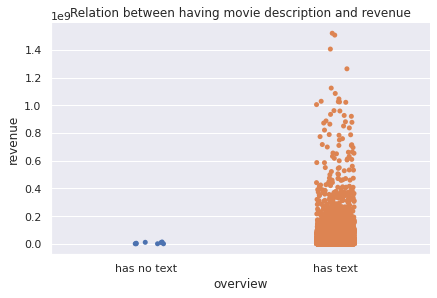

In [296]:
# Relation between movies with description or witout description and revenue
sns.catplot(x=train['overview'].apply(lambda x: 0 if pd.isnull(x) else 1), 
            y='revenue', data=train, height=4, aspect=1.5)\
            .set_xticklabels(['has no text', 'has text'])
plt.title('Relation between having movie description and revenue')
plt.show()

#### 2.15. popularity column <a name="heading--2-15"/>

In [297]:
train['popularity'][:10]

0    6.5754
1    8.2489
2   64.3000
3    3.1749
4    1.1481
5    0.7433
6    7.2865
7    1.9490
8    6.9024
9    4.6720
Name: popularity, dtype: float64

In [298]:
# chcecking how many null values in popularity column are
train['popularity'].isna().value_counts()

False    3000
Name: popularity, dtype: int64

In [299]:
train['popularity'].describe()

count   3000.0000
mean       8.4633
std       12.1040
min        0.0000
25%        4.0181
50%        7.3749
75%       10.8910
max      294.3370
Name: popularity, dtype: float64

In [300]:
# 20 most popular movies
most_popular_movies = train.sort_values('popularity', ascending=False).head(20)
most_popular_movies[['title', 'popularity', 'release_date', 'revenue']]

,title,popularity,release_date,revenue
518,Wonder Woman,294.3370,5/30/17,820580447
684,Beauty and the Beast,287.2537,3/16/17,1262886337
1695,Baby Driver,228.0327,6/28/17,224511319
2326,Deadpool,187.8605,2/9/16,783112979
2126,Guardians of the Galaxy Vol. 2,185.3310,4/19/17,863416141
1309,Gone Girl,154.8010,10/1/14,369330363
1715,War for the Planet of the Apes,146.1618,7/11/17,369907963
1673,The Dark Knight,123.1673,7/16/08,1004558444
1126,The Avengers,89.8876,4/25/12,1519557910
2293,The Circle,88.4392,4/27/17,20497844


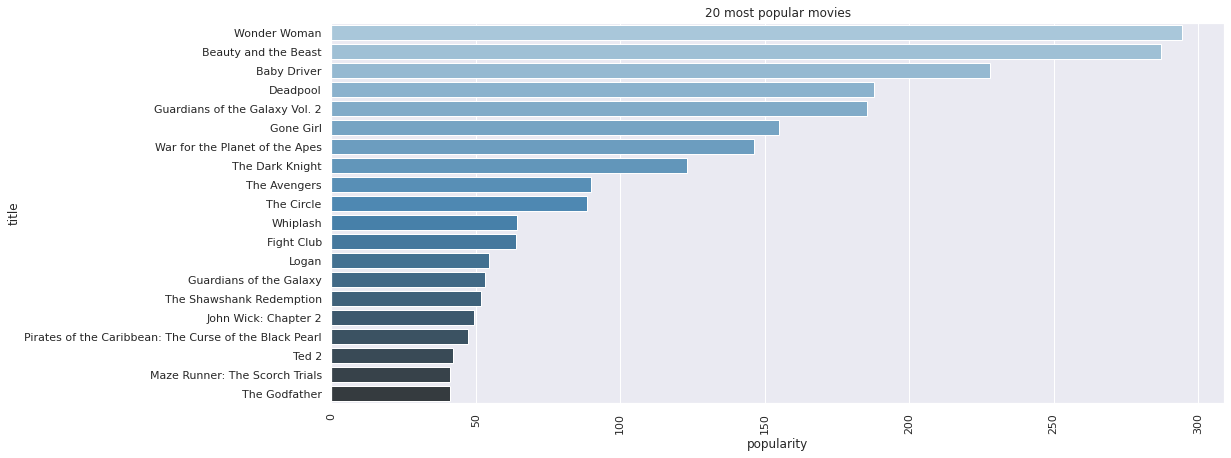

In [301]:
# 20 most popular movies - plot
fig = plt.figure(figsize=(16, 7))
sns.barplot(x=most_popular_movies['popularity'],
            y=most_popular_movies['title'],
            palette="Blues_d", orient='h')
plt.title('20 most popular movies')
plt.xticks(rotation=90)
plt.show()

In [302]:
# 20 least popular movies
least_popular_movies = train.sort_values('popularity').head(20)
least_popular_movies[['title', 'popularity', 'release_date', 'revenue']]

,title,popularity,release_date,revenue
2556,Big Time,0.0000,9/15/88,148426
1683,The Slugger's Wife,0.0003,3/29/85,1878561
741,And You Thought Your Parents Were Weird!,0.0006,11/15/91,402539
1503,Campus Man,0.0008,4/10/87,989000
773,Live Nude Girls Unite!,0.0013,10/6/00,48752
1800,The Cherry Orchard,0.0019,1/1/99,135
2302,Happy Weekend,0.0022,3/14/96,65335
457,Swoon,0.0030,9/11/92,340147
862,"Hey, Boo: Harper Lee & To Kill a Mockingbird",0.0073,5/13/11,26488
1007,Billy Gardell: Halftime,0.0079,2/5/11,60


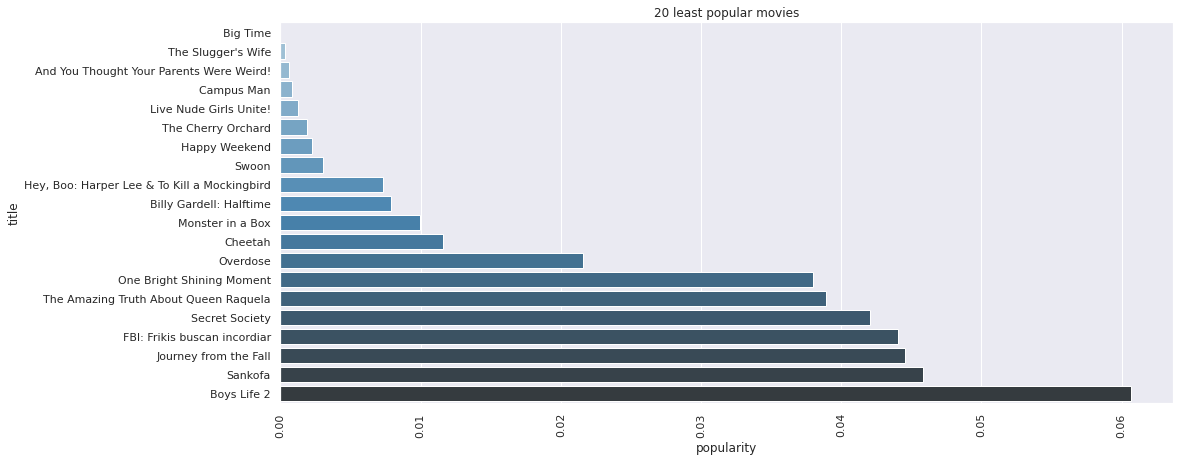

In [303]:
# 20 least popular movies - plot
fig = plt.figure(figsize=(16, 7))
sns.barplot(x=least_popular_movies['popularity'],
            y=least_popular_movies['title'],
            palette="Blues_d", orient='h')
plt.title('20 least popular movies')
plt.xticks(rotation=90)
plt.show()

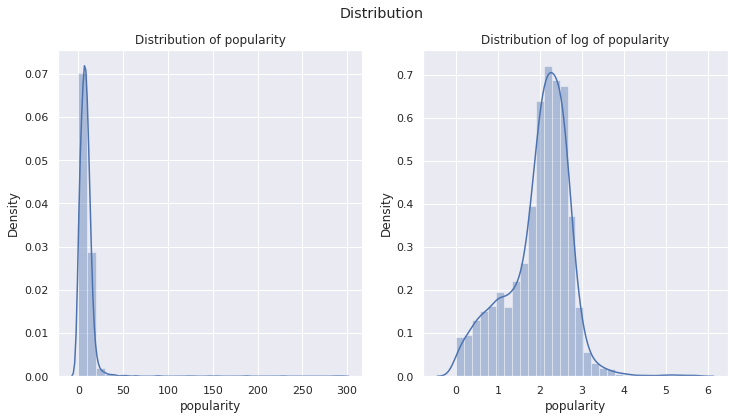

In [304]:
# Distribution of popularity
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
sns.distplot(train['popularity'], bins=30, ax=ax[0])
sns.distplot(np.log1p(train['popularity']), bins=30, ax=ax[1])

fig.suptitle('Distribution')
ax[0].title.set_text('Distribution of popularity')
ax[1].title.set_text('Distribution of log of popularity')

Text(0.5, 1.0, 'Log Revenue vs log popularity')

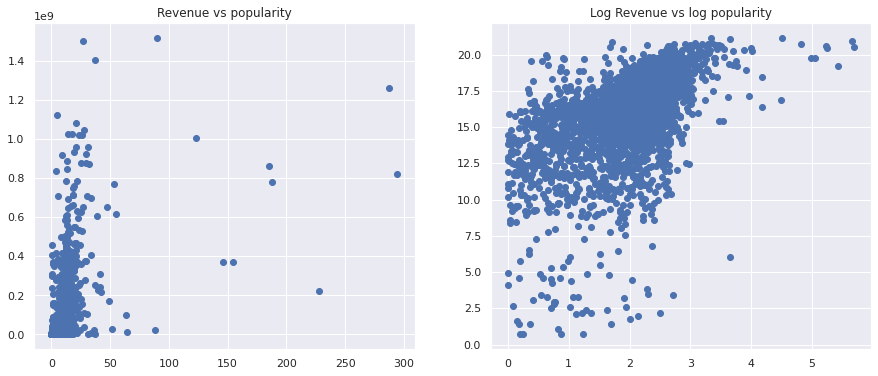

In [305]:
# Relationship between popularity and revenue
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.scatter(train['popularity'], train['revenue'])
plt.title('Revenue vs popularity')
plt.subplot(1, 2, 2)
plt.scatter(np.log1p(train['popularity']), train['log_revenue'])
plt.title('Log Revenue vs log popularity')

#### 2.16. poster_path column <a name="heading--2-16"/>

In [306]:
train['poster_path'][:10]

0    /tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg
1    /w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg
2    /lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg
3    /aTXRaPrWSinhcmCrcfJK17urp3F.jpg
4    /m22s7zvkVFDU9ir56PiiqIEWFdT.jpg
5    /6IDqA1D2NBIVhzEEaMMRL28iBrq.jpg
6    /4QjzFuaZmB4btGnLwAgdp23BzIU.jpg
7    /83BV8fGy5p9i8RwE9oj76tZ1Ikp.jpg
8    /5A8gKzOrF9Z7tSUX6xd5dEx4NXf.jpg
9    /xwD4EsPOGLuKP50Q1gwqAsyhAFB.jpg
Name: poster_path, dtype: object

In [307]:
# chcecking how many null values in popularity column are
train['poster_path'].isna().value_counts()

False    2999
True        1
Name: poster_path, dtype: int64

In [308]:
train[train['poster_path'].isna()]

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue,log_revenue
2302,2303,{},0,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt0116485,de,Happy Weekend,NaN,0.0022,NaN,"[{'name': 'Senator Film Produktion', 'id': 191}]","[{'iso_3166_1': 'DE', 'name': 'Germany'}]",3/14/96,nan,"[{'iso_639_1': 'de', 'name': 'Deutsch'}]",Released,NaN,Happy Weekend,"[{'id': 572, 'name': 'sex'}, {'id': 596, 'name...","[{'cast_id': 0, 'character': 'Joachim Krippo',...",{},65335,11.0873


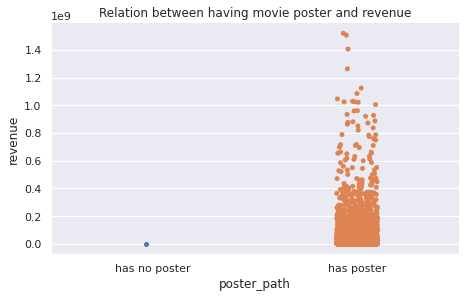

In [309]:
# Relation between movies with poster or witout poster and revenue
sns.catplot(x=train['poster_path'].apply(lambda x: 0 if pd.isnull(x) else 1), 
            y='revenue', data=train, height=4, aspect=1.6)\
            .set_xticklabels(['has no poster', 'has poster'])
plt.title('Relation between having movie poster and revenue')
plt.show()

only one movie has no poster so it does not impact on the model. It will be deleted

#### 2.17. release_date column <a name="heading--2-17"/>

In [310]:
train['release_date'][:10]

0     2/20/15
1      8/6/04
2    10/10/14
3      3/9/12
4      2/5/09
5      8/6/87
6     8/30/12
7     1/15/04
8     2/16/96
9     4/16/03
Name: release_date, dtype: object

Checking if in train and test sets there are null values in 'release_date'

In [311]:
train[['title', 'release_date']][train['release_date'].isnull()]

,title,release_date


In [312]:
test[['title', 'release_date']][test['release_date'].isnull()]

,title,release_date
828,"Jails, Hospitals & Hip-Hop",NaN


In [313]:
# Movie 'Jails, Hospitals & Hip-Hop' has no defined release_date so from 
# https://www.imdb.com/title/tt0210130/ website the release date is 05.2000
# df.loc[df[<some_column_name>] == <condition>, [<another_column_name>]] = <value_to_add>

test.loc[test['release_date'].index == 828, 'release_date'] = '05/01/00'
test[['title', 'release_date']][(test['release_date'].index == 828)]

,title,release_date
828,"Jails, Hospitals & Hip-Hop",05/01/00


Year in released_date is 2 digit number so it is better to change it to 4 digit number. But released date of movies are to from 1921 to 2017. First it is needed to transform years 21 to 70 because they are 1921 - 1970 not 2021 - 2070

In [314]:
def fix_date(x):
    """
    Fix dates which are in 20xx
    """
    year = x.split('/')[2]
    if int(year)<20:
        return x[:-2] + '20' + year
    else:
        return x[:-2] + '19' + year
    
train['release_date'] = train['release_date'].apply(lambda x:fix_date(x))  
test['release_date'] = test['release_date'].apply(lambda x:fix_date(x))

print(train['release_date'][0])
print(test['release_date'][0])

2/20/2015
7/14/2007


In [315]:
train['release_date'] = pd.to_datetime(train['release_date'])
test['release_date'] = pd.to_datetime(test['release_date'])

In [316]:
train['release_year'] = train['release_date'].dt.year
train['release_month'] = train['release_date'].dt.month
train['release_day'] = train['release_date'].dt.day
train['release_dayofweek'] = train['release_date'].dt.dayofweek

test['release_year'] = test['release_date'].dt.year
test['release_month'] = test['release_date'].dt.month
test['release_day'] = test['release_date'].dt.day
test['release_dayofweek'] = test['release_date'].dt.dayofweek

train.drop(['release_date'], axis=1, inplace=True)
test.drop(['release_date'], axis=1, inplace=True)

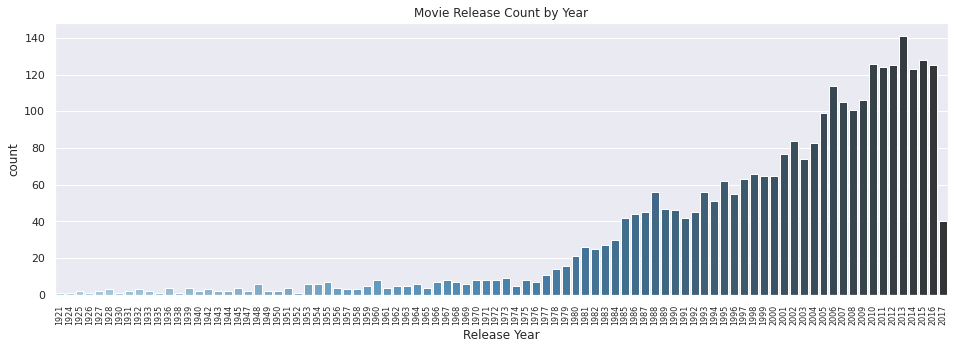

In [317]:
# Number of movies by year
plt.figure(figsize=(16,5))
sns.countplot(train['release_year'].sort_values(), palette="Blues_d")
plt.title("Movie Release Count by Year")
plt.xlabel("Release Year")
plt.xticks(fontsize=8, rotation=90)
plt.show()

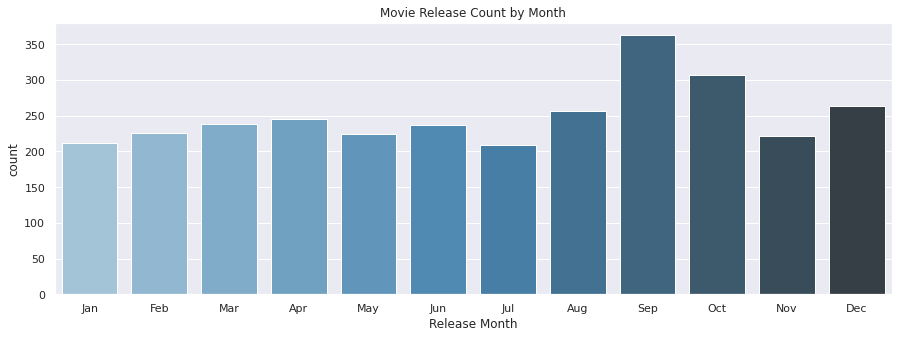

In [318]:
# Number of movies by month
months_list = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 
               'Oct', 'Nov', 'Dec']
plt.figure(figsize=(15,5))
sns.countplot(train['release_month'].sort_values(), palette="Blues_d")\
.set_xticklabels(months_list)
plt.title("Movie Release Count by Month")
plt.xlabel("Release Month")
plt.show()

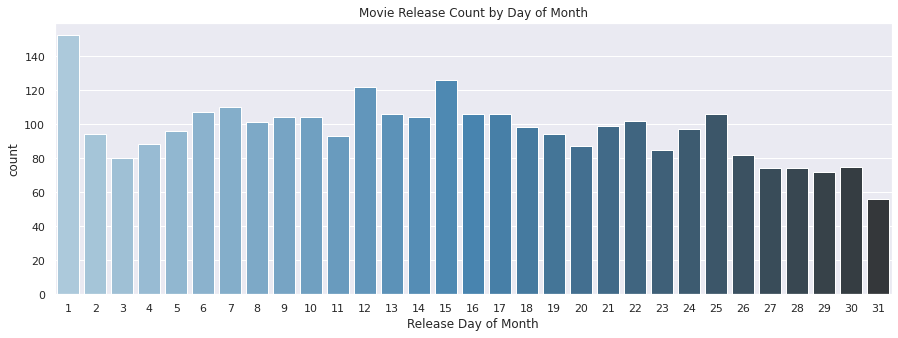

In [319]:
# Number of movies by day of month
plt.figure(figsize=(15,5))
sns.countplot(train['release_day'].sort_values(), palette="Blues_d")
plt.title("Movie Release Count by Day of Month")
plt.xlabel("Release Day of Month")
plt.show()

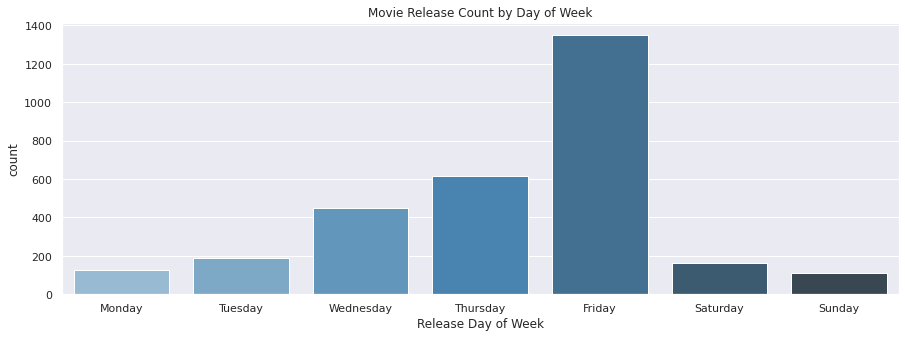

In [320]:
# Number of movies by day of week
plt.figure(figsize=(15,5))
sns.countplot(train['release_dayofweek'].sort_values(), palette="Blues_d")\
.set_xticklabels(["Monday","Tuesday","Wednesday","Thursday","Friday",
                  "Saturday","Sunday"])
plt.title("Movie Release Count by Day of Week")
plt.xlabel("Release Day of Week")
plt.show()

#### 2.18. runtime column <a name="heading--2-18"/>

In [321]:
train['runtime'][:10]

0    93.0000
1   113.0000
2   105.0000
3   122.0000
4   118.0000
5    83.0000
6    92.0000
7    84.0000
8   100.0000
9    91.0000
Name: runtime, dtype: float64

In [322]:
# chcecking how many null values in runtime column are
train['runtime'].isna().value_counts()

False    2998
True        2
Name: runtime, dtype: int64

Checking from websites movies with null values in 'runtime' train and test sets and adding that runtime

- Королёв - https://www.imdb.com/title/tt1107828/ = 130 min
- Happy Weekend - https://www.german-films.de/filmarchive/browse-archive/view/detail/film/happy-weekend/index.html = 94 min


In [323]:
train[['title', 'release_year', 'runtime']][train['runtime'].isnull()]

,title,release_year,runtime
1335,Королёв,2007,nan
2302,Happy Weekend,1996,nan


In [324]:
train.loc[train['runtime'].index == 1335, 'runtime'] = 130
train.loc[train['runtime'].index == 2302, 'runtime'] = 94

train[['title', 'release_year', 'runtime']][(train['runtime'].index == 1335) \
                                            | (train['runtime'].index == 2302)]

,title,release_year,runtime
1335,Королёв,2007,130.0000
2302,Happy Weekend,1996,94.0000


- La caliente niña Julietta - https://www.imdb.com/title/tt0082131/?ref_=adv_li_tt = 93 min
- Pancho, el perro millonario - https://www.imdb.com/title/tt3132094/?ref_=fn_al_tt_1 = 91 min
- Nunca en horas de clase - https://www.imdb.com/title/tt0078010/technical = 100 min
- Miesten välisiä keskusteluja - https://www.imdb.com/title/tt2192844/ = 90 min

In [325]:
test[['title', 'release_year', 'runtime']][test['runtime'].isnull()]

,title,release_year,runtime
243,La caliente niña Julietta,1981,nan
1489,"Pancho, el perro millonario",2014,nan
1632,Nunca en horas de clase,1978,nan
3817,Miesten välisiä keskusteluja,2013,nan


In [326]:
test.loc[test['runtime'].index == 243, 'runtime'] = 93
test.loc[test['runtime'].index == 1489, 'runtime'] = 91
test.loc[test['runtime'].index == 1632, 'runtime'] = 100
test.loc[test['runtime'].index == 3817, 'runtime'] = 90

test[['title', 'release_year', 'runtime']][(test['runtime'].index == 243) \
                                            | (test['runtime'].index == 1489)\
                                            | (test['runtime'].index == 1632)\
                                            | (test['runtime'].index == 3817)]

,title,release_year,runtime
243,La caliente niña Julietta,1981,93.0000
1489,"Pancho, el perro millonario",2014,91.0000
1632,Nunca en horas de clase,1978,100.0000
3817,Miesten välisiä keskusteluja,2013,90.0000


Checking if  movies are 0 minutes of runtime. They will be changed.

In [327]:
train[['title', 'release_year', 'runtime']][train['runtime'] == 0]

,title,release_year,runtime
390,The Worst Christmas of My Life,2012,0.0000
591,А поутру они проснулись,2003,0.0000
924,¿Quién mató a Bambi?,2013,0.0000
977,La peggior settimana della mia vita,2011,0.0000
1255,"Cry, Onion!",1975,0.0000
1541,All at Once,2014,0.0000
1874,Missing,2007,0.0000
2150,Mechenosets,2006,0.0000
2498,Hooked on the Game 2. The Next Level,2010,0.0000
2645,My Old Classmate,2014,0.0000


Runtime in minutes from imdb.com website
- The Worst Christmas of My Life - https://www.imdb.com/title/tt2550838/?ref_=nv_sr_srsg_0 = 116
- А поутру они проснулись - https://www.imdb.com/title/tt0768690/ = 120
- ¿Quién mató a Bambi? - https://www.imdb.com/title/tt2604346/?ref_=fn_al_tt_1 = 116
- La peggior settimana della mia vita - https://www.imdb.com/title/tt2076251/?ref_=nv_sr_srsg_0 = 123
- Cry, Onion! - https://www.imdb.com/title/tt0072785/?ref_=fn_al_tt_1 = 123
- All at Once - https://www.imdb.com/title/tt3805180/?ref_=fn_al_tt_2 = 123
- Missing - https://www.imdb.com/title/tt1141264/ = 12
- Mechenosets - https://www.imdb.com/title/tt0477337/?ref_=fn_al_tt_1 = 138
- Hooked on the Game 2. The Next Level - https://www.imdb.com/title/tt1620549/?ref_=nv_sr_srsg_0 = 116
- My Old Classmate - https://www.imdb.com/title/tt3956312/?ref_=nv_sr_srsg_0 = 128
- Revelation - https://www.imdb.com/title/tt0278675/ = 141
- Tutto tutto niente niente - https://www.imdb.com/title/tt2456720/?ref_=nv_sr_srsg_0 = 126

In [328]:
train.loc[train['runtime'].index == 390, 'runtime'] = 116
train.loc[train['runtime'].index == 591, 'runtime'] = 120
train.loc[train['runtime'].index == 924, 'runtime'] = 116
train.loc[train['runtime'].index == 977, 'runtime'] = 123
train.loc[train['runtime'].index == 1255, 'runtime'] = 123
train.loc[train['runtime'].index == 1541, 'runtime'] = 123
train.loc[train['runtime'].index == 1874, 'runtime'] = 12
train.loc[train['runtime'].index == 2150, 'runtime'] = 138
train.loc[train['runtime'].index == 2498, 'runtime'] = 116
train.loc[train['runtime'].index == 2645, 'runtime'] = 128
train.loc[train['runtime'].index == 2785, 'runtime'] = 141
train.loc[train['runtime'].index == 2865, 'runtime'] = 126

train[['title', 'release_year', 'runtime']][(train['runtime'].index == 390) \
                                            | (train['runtime'].index == 591) \
                                            | (train['runtime'].index == 924) \
                                            | (train['runtime'].index == 977) \
                                            | (train['runtime'].index == 1255) \
                                            | (train['runtime'].index == 1541) \
                                            | (train['runtime'].index == 1874) \
                                            | (train['runtime'].index == 2150) \
                                            | (train['runtime'].index == 2498) \
                                            | (train['runtime'].index == 2645) \
                                            | (train['runtime'].index == 2785) \
                                            | (train['runtime'].index == 2865)]

,title,release_year,runtime
390,The Worst Christmas of My Life,2012,116.0000
591,А поутру они проснулись,2003,120.0000
924,¿Quién mató a Bambi?,2013,116.0000
977,La peggior settimana della mia vita,2011,123.0000
1255,"Cry, Onion!",1975,123.0000
1541,All at Once,2014,123.0000
1874,Missing,2007,12.0000
2150,Mechenosets,2006,138.0000
2498,Hooked on the Game 2. The Next Level,2010,116.0000
2645,My Old Classmate,2014,128.0000


In [329]:
train[['title', 'release_year', 'runtime']][train['runtime'] == 0]

,title,release_year,runtime


In test set for movies with runtime=0 the runtime is changed to average runtime of the release year

In [330]:
test[['title','runtime']][test['runtime'] == 0]

,title,runtime
1073,Shikshanachya Aaicha Gho,0.0000
1221,Street Knight,0.0000
1430,Plus one,0.0000
2519,Glukhar v kino,0.0000
2844,Frau Müller muss weg!,0.0000
2848,Shabd,0.0000
3209,The Last Breath,0.0000
3803,Chaahat Ek Nasha...,0.0000
4320,El truco del manco,0.0000


In [331]:
# replacing 0 values in runtime in test set to average runtime of the year
test['runtime'] = test['runtime'].replace(0, np.nan)
test['runtime'] = test['runtime'].fillna(test.groupby('release_year')['runtime']\
                                         .transform('mean'))

In [332]:
test[['title','runtime']][test['runtime'] == 0]

,title,runtime


In [333]:
train["runtime"].value_counts()

90.0000     100
100.0000     99
105.0000     91
95.0000      89
98.0000      85
           ... 
62.0000       1
66.0000       1
248.0000      1
12.0000       1
177.0000      1
Name: runtime, Length: 139, dtype: int64

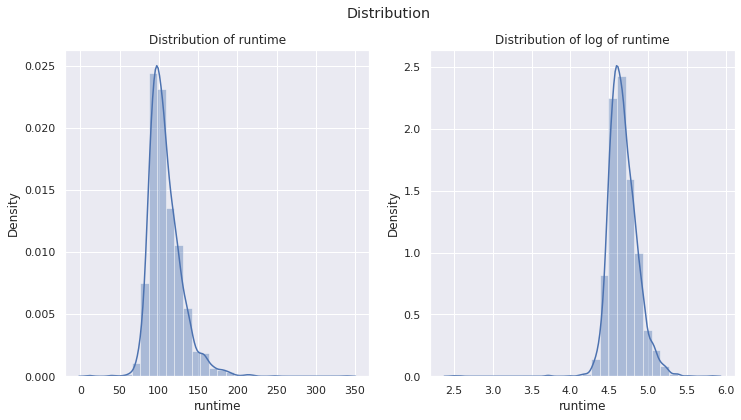

In [334]:
# Distribution of runtime
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
sns.distplot(train['runtime'], bins=30, ax=ax[0])
sns.distplot(np.log1p(train['runtime']), bins=30, ax=ax[1])

fig.suptitle('Distribution')
ax[0].title.set_text('Distribution of runtime')
ax[1].title.set_text('Distribution of log of runtime')

Text(0.5, 1.0, 'Log Revenue vs log runtime')

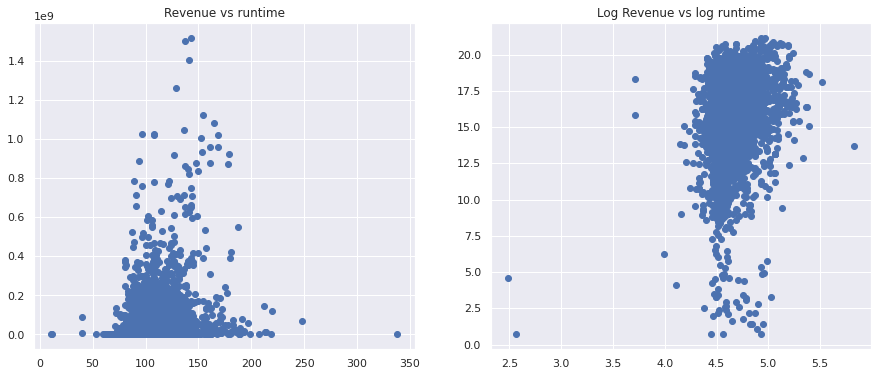

In [335]:
# Relationship between runtime and revenue
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.scatter(train['runtime'], train['revenue'])
plt.title('Revenue vs runtime')
plt.subplot(1, 2, 2)
plt.scatter(np.log1p(train['runtime']), train['log_revenue'])
plt.title('Log Revenue vs log runtime')

There is no visible relationship between the runtime and the revenue. So it is no needed to give log_runtime to modeling

#### 2.19. status column <a name="heading--2-19"/>

In [336]:
train['status'][:10]

0    Released
1    Released
2    Released
3    Released
4    Released
5    Released
6    Released
7    Released
8    Released
9    Released
Name: status, dtype: object

In [337]:
train['status'].value_counts()

Released    2996
Rumored        4
Name: status, dtype: int64

In [338]:
train[['title','status']][train['status'] == 'Rumored']

,title,status
609,The Swan Princess: Escape from Castle Mountain,Rumored
1007,Billy Gardell: Halftime,Rumored
1216,Extremities,Rumored
1618,A Place Called Chiapas,Rumored


Only 4 movies havn't been released, so this column is not very useful.

#### 2.20. tagline column <a name="heading--2-20"/>

In [339]:
train['tagline'][:10]

0    The Laws of Space and Time are About to be Vio...
1    It can take a lifetime to find true love; she'...
2      The road to greatness can take you to the edge.
3                                                  NaN
4                                                  NaN
5                                                  NaN
6                 Fear The Demon That Doesn't Fear God
7                Different channels. Different truths.
8                          Set sail for Muppet mayhem!
9             Back together for the first time, again.
Name: tagline, dtype: object

In [340]:
# chcecking how many null values in popularity column are
train['tagline'].isna().value_counts()

False    2403
True      597
Name: tagline, dtype: int64

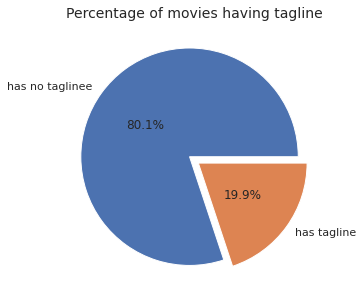

In [341]:
plt.figure(figsize=(5,5))
plt.pie(x=train['tagline'].isna().value_counts(), autopct="%.1f%%", 
        explode=[0.05]*2, labels=['has no taglinee', 'has tagline'], 
        pctdistance=0.5)
plt.title("Percentage of movies having tagline", fontsize=14)
plt.show()

In [342]:
train['tagline'].value_counts()[:10]

Based on a true story.                                                                                          3
Who is John Galt?                                                                                               2
The gates of hell are unlocked.                                                                                 1
They proved the Vegas Blackjack System was beatable...by beating the hell out of it.                            1
America's Most Wanted.                                                                                          1
A comic tale of horror and seduction.                                                                           1
A Small Town on the Outskirts of Greatness.                                                                     1
Information is power.                                                                                           1
Temptation can lead anywhere.                                                           

tagline is not useful. The information which can be important is a movie has a tagline or not. Let's check if there is a relation between a movie has a tagline or not and revenue 

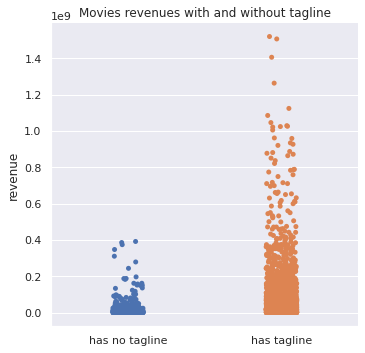

In [343]:
sns.catplot(data=train, x=np.where(train['tagline'].isna(), 0, 1), y='revenue')\
.set_xticklabels(['has no tagline', 'has tagline'])
plt.title('Movies revenues with and without tagline')
plt.show()

#### 2.21. title column <a name="heading--2-21"/>

In [344]:
train['title'][:10]

0                      Hot Tub Time Machine 2
1    The Princess Diaries 2: Royal Engagement
2                                    Whiplash
3                                     Kahaani
4                                  Marine Boy
5      Pinocchio and the Emperor of the Night
6                              The Possession
7                                Control Room
8                      Muppet Treasure Island
9                               A Mighty Wind
Name: title, dtype: object

In [345]:
# chcecking how many null values in title column are
train['title'].isna().value_counts()

False    3000
Name: title, dtype: int64

In [346]:
train['title'].value_counts()[:10]

King Kong               2
Logan                   2
Stolen                  2
Ghost                   2
The Three Musketeers    2
Black Sheep             2
Deadfall                2
Scarface                2
Lolita                  2
Joshua                  2
Name: title, dtype: int64

The same situation like in original_title. Every movie has its own title, some has the same title but these are different movies. So this feature will be deleted

#### 2.22. budget column <a name="heading--2-22"/>

In [347]:
train['budget'][:10]

0    14000000
1    40000000
2     3300000
3     1200000
4           0
5     8000000
6    14000000
7           0
8           0
9     6000000
Name: budget, dtype: int64

In [348]:
# chcecking how many null values in title column are
train['budget'].isna().value_counts()

False    3000
Name: budget, dtype: int64

Movie budget shouldn't be 0. So let's check how many movies had budget equals 0.

In [349]:
train['budget'][train['budget'] == 0].count()

812

Some examples of movies where budget equals zero

In [350]:
train[['title', 'budget']][train['budget'] == 0]

,title,budget
4,Marine Boy,0
7,Control Room,0
8,Muppet Treasure Island,0
11,Revenge of the Nerds II: Nerds in Paradise,0
17,The Invisible Woman,0
...,...,...
2989,The Trumpet Of The Swan,0
2990,B.A.P.S.,0
2994,School Ties,0
2995,Chasers,0


In [351]:
highest_budget_movies = train.sort_values('budget', ascending=False).head(20)
highest_budget_movies[['title', 'release_year', 'budget', 'revenue']]

,title,release_year,budget,revenue
2135,Pirates of the Caribbean: On Stranger Tides,2011,380000000,1045713802
2209,Pirates of the Caribbean: At World's End,2007,300000000,961000000
2770,Avengers: Age of Ultron,2015,280000000,1405403694
1425,Superman Returns,2006,270000000,391081192
1270,John Carter,2012,260000000,284139100
1630,Transformers: The Last Knight,2017,260000000,604942143
2532,The Hobbit: An Unexpected Journey,2012,250000000,1021103568
961,Harry Potter and the Half-Blood Prince,2009,250000000,933959197
906,The Dark Knight Rises,2012,250000000,1084939099
666,The Hobbit: The Desolation of Smaug,2013,250000000,958400000


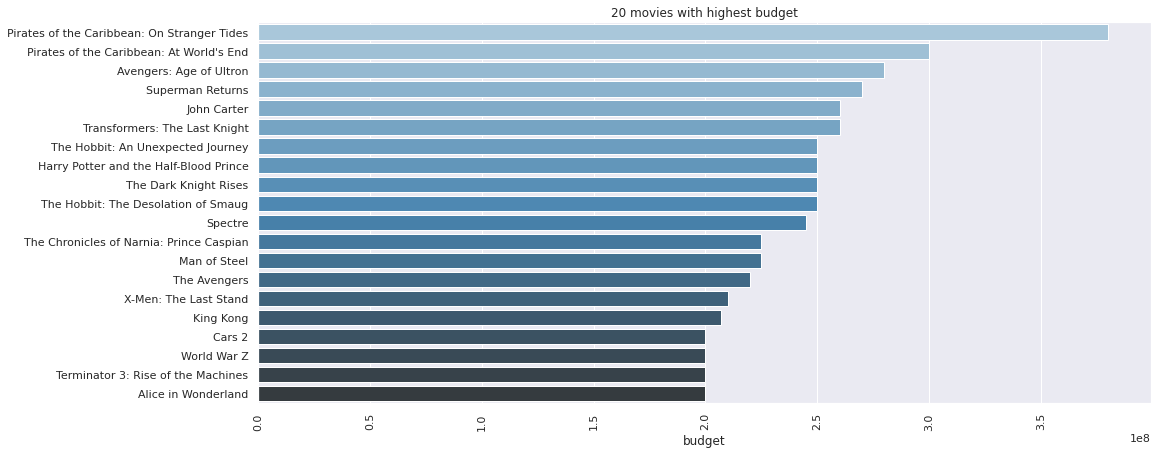

In [352]:
# 20 movies with highest budget - plot
fig = plt.figure(figsize=(16, 7))
sns.barplot(x=highest_budget_movies['budget'],
            y=highest_budget_movies['title'],
            palette="Blues_d", orient='h')
plt.title('20 movies with highest budget')
plt.ylabel('')
plt.xticks(rotation=90)
plt.show()

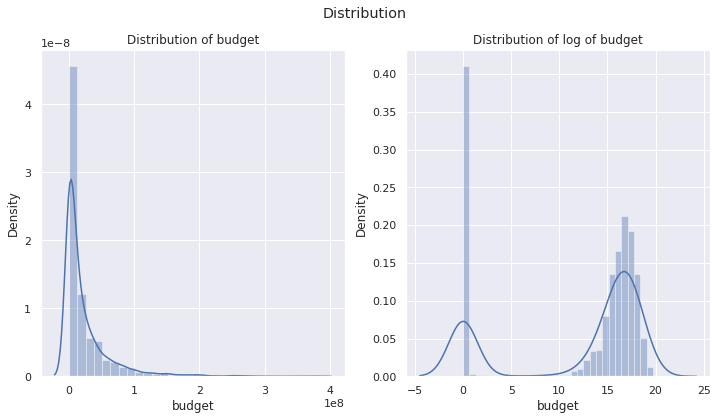

In [353]:
# Distribution of budget

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
sns.distplot(train['budget'], bins=30, ax=ax[0])
sns.distplot(np.log1p(train['budget']), bins=30, ax=ax[1])

fig.suptitle('Distribution')
ax[0].title.set_text('Distribution of budget')
ax[1].title.set_text('Distribution of log of budget')

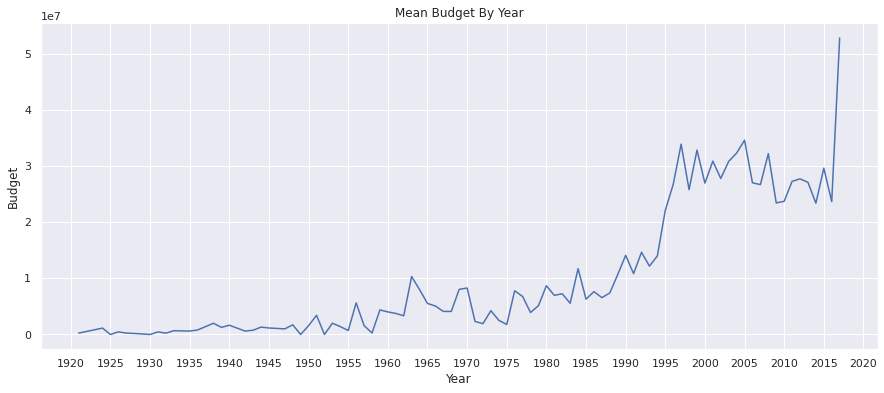

In [354]:
# Mean budget by year
mean_budget_by_year = train.groupby(train['release_year'])['budget'].agg('mean')
mean_budget_by_year.plot(figsize=(15,6))
plt.xlabel('Year')
plt.ylabel('Budget')
plt.title('Mean Budget By Year')
plt.xticks(np.arange(1920,2021,5))
plt.show()

Text(0.5, 1.0, 'Log Revenue vs log budget')

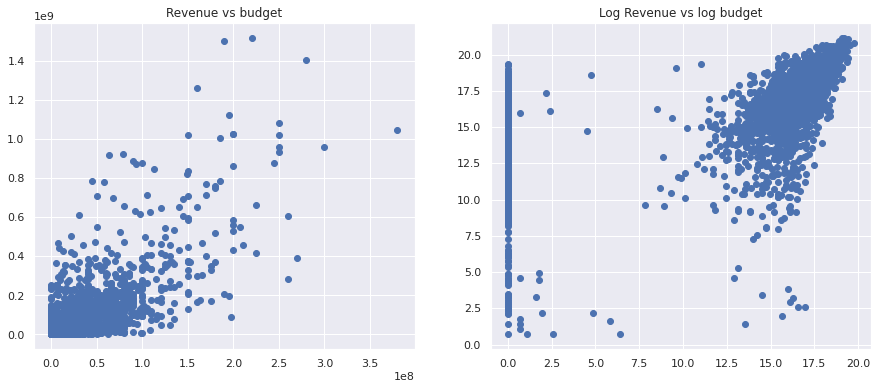

In [355]:
# Relationship between budget and revenue
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.scatter(train['budget'], train['revenue'])
plt.title('Revenue vs budget')
plt.subplot(1, 2, 2)
plt.scatter(np.log1p(train['budget']), train['log_revenue'])
plt.title('Log Revenue vs log budget')

budget and revenue are highly correlated and there is linear relationship between them

### 3. Data Preprocessing <a name="heading--3"/>

#### 3.1. Correlation with revenue <a name="heading--3-1"/>

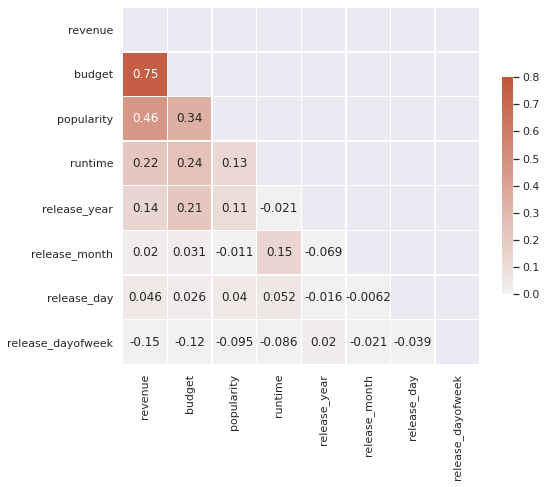

In [356]:
num_cols = ['revenue', 'budget', 'popularity', 'runtime', 'release_year', 
            'release_month', 'release_day', 'release_dayofweek']

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(train[num_cols].corr(), dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8, 8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(train[num_cols].corr(), annot=True, mask=mask, cmap=cmap, vmax=.8, center=0, vmin=-.0, 
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

There are strong correlation between budget, popularity, runtime and release year

#### 3.2. Adding new features <a name="heading--3-2"/>

Name of collection is not important for the model. Better information is if movie has collection or not. If so the movie gets 1 and if not it gets 0.
The same situation is with homepage and tagline. 

In [357]:
train ['has_collection'] = np.where(train['belongs_to_collection'].isna(), 0, 1)
test ['has_collection'] = np.where(test['belongs_to_collection'].isna(), 0, 1)

train['has_homepage'] = np.where(train['homepage'].isna(), 0, 1)
test['has_homepage'] = np.where(test['homepage'].isna(), 0, 1)

train['has_tagline'] = np.where (train['tagline'].isna(), 0, 1)
test['has_tagline'] = np.where (test['tagline'].isna(), 0, 1)

Almost all all movies have been released. Only 4 not. So it is better to add column where is 1 for released movie and 0 for not released.

In [358]:
train['is_released'] = np.where(train['status'] != 'Released', 0, 1)
test['is_released'] = np.where(test['status'] != 'Released', 0, 1)

For columns that are texts it is taken the len of each col and quantity of words as a feature to model

In [359]:
for col in ['title', 'original_title', 'tagline', 'overview']:
    train['len_' + col] = train[col].fillna('').apply(lambda x: len(str(x)))
    train['words_' + col] = train[col].fillna('').apply(lambda x: len(x.split(' ')))
    test['len_' + col] = test[col].fillna('').apply(lambda x: len(str(x)))
    test['words_' + col] = test[col].fillna('').apply(lambda x: len(x.split(' ')))

budget

In [360]:
# Converting the budget with Logarithms to overcome the skewness and the outliers
train['budget'] = np.log1p(train['budget'])
test['budget'] = np.log1p(test['budget'])


# replacing 0 values in budget to average budget of the year
train['budget'] = train['budget'].replace(0, np.nan)
train['budget'] = train['budget'].fillna(train.groupby('release_year')['budget']\
                                         .transform('mean'))

test['budget'] = test['budget'].replace(0, np.nan)
test['budget'] = test['budget'].fillna(test.groupby('release_year')['budget']\
                                         .transform('mean'))

# adding new features related to budget
train['ratio_budget_runtime'] = train['budget'] / train['runtime']
train['ratio_budget_popularity'] = train['budget'] / np.log1p(train['popularity'])
train['ratio_budget_year'] = train['budget'] / train['release_year']
train['budget_to_mean_year'] \
= train['budget'] / train.groupby("release_year")["budget"].transform('mean')

test['ratio_budget_runtime'] = test['budget'] / test['runtime']
test['ratio_budget_popularity'] = test['budget'] / np.log1p(test['popularity'])
test['ratio_budget_year'] = test['budget'] / test['release_year']
test['budget_to_mean_year'] \
= test['budget'] / test.groupby("release_year")["budget"].transform('mean')

In [361]:
train[['title', 'budget', 'release_year']][train.budget.isna()]

,title,budget,release_year
333,Twelve O'Clock High,nan,1949
644,Ikiru,nan,1952
1667,The Third Man,nan,1949
2323,L'Âge d'Or,nan,1930


In train set for some years (1930, 1949 and 1952) there are undefined budgets so average budget of that years are not working. Budgets for that 3 years will be replaced by 1 (1 because it is used to 'budget_to_mean_year', 'ratio_budget_year', 'ratio_budget_popularity' and 'ratio_budget_runtime').

In [362]:
train['budget'].fillna(1, inplace=True)

train[['title','budget', 'release_year']][(train['release_year']==1930) \
                                  | (train['release_year']==1949) \
                                  | (train['release_year']==1952)]

,title,budget,release_year
333,Twelve O'Clock High,1.0000,1949
644,Ikiru,1.0000,1952
1667,The Third Man,1.0000,1949
2323,L'Âge d'Or,1.0000,1930


In [363]:
train.budget.isna().sum()

0

In test set for year 1923 there is undefined budget too, so it will be replaced by 1

In [364]:
test[['title', 'budget', 'release_year']][test['budget'].isna()]

,title,budget,release_year
2925,Safety Last!,nan,1923


In [365]:
test['budget'].fillna(1, inplace=True)

test[['title','budget', 'release_year']][test['release_year']==1923]

,title,budget,release_year
2925,Safety Last!,1.0000,1923


In [366]:
test.budget.isna().sum()

0

popularity

In [367]:
# Converting the popularity with Logarithms to overcome the skewness and the outliers
train['popularity'] = np.log1p(train['popularity'])
test['popularity'] = np.log1p(test['popularity'])

# adding new features related to popularity
train['ratio_popularity_year'] = train['popularity'] / train['release_year']
train['popularity_to_mean_year'] = train['popularity'] / train.groupby('release_year')['popularity'].transform('mean')

test['ratio_popularity_year'] = test['popularity'] / test['release_year']
test['popularity_to_mean_year'] = test['popularity'] / test.groupby('release_year')['popularity'].transform('mean')


runtime

In [368]:
# adding new features related to runtime
train['ratio_runtime_year'] = train['runtime'] / train['release_year']
train['runtime_to_mean_year'] = train['runtime'] / train.groupby('release_year')['runtime'].transform('mean')

test['ratio_runtime_year'] = test['runtime'] / test['release_year']
test['runtime_to_mean_year'] = test['runtime'] / test.groupby('release_year')['runtime'].transform('mean')

cast

In [369]:
# adding new features related to cast - gender of the cast: Male 2, Female 1 and 0 is Unassigned
train['num_cast'] = train['cast'].apply(lambda x: [i['name'] for i in x] if x!={} else []).apply(len)
train['unassigned_cast_num'] = train['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
train['actresses_num'] = train['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
train['actors_num'] = train['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))

test['num_cast'] = test['cast'].apply(lambda x: [i['name'] for i in x] if x!={} else []).apply(len)
test['unassigned_cast_num'] = test['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
test['actresses_num'] = test['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
test['actors_num'] = test['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))

crew

In [370]:
# adding new features related to cast - gender of the crew: Male 2, Female 1 and 0 is Unassigned
train['num_crew'] = train['crew'].apply(lambda x: [i['name'] for i in x] if x!={} else []).apply(len)
train['unassigned_crew_num'] = train['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
train['female_crew_num'] = train['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
train['male_crew_num'] = train['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))

test['num_crew'] = test['crew'].apply(lambda x: [i['name'] for i in x] if x!={} else []).apply(len)
test['unassigned_crew_num'] = test['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
test['female_crew_num'] = test['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
test['male_crew_num'] = test['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))

original_language

In [371]:
# adding new features related to original language for languages 
# which are exist in more than 10 movies
value_count_original_language = Counter(train['original_language']).most_common()
top_list_lang = [m[0] for m in value_count_original_language if m[1] > 10]

for p in top_list_lang: 
    train['original_language_' + p] = train['original_language'].apply(lambda x: 1 if p in x else 0)
    test['original_language_' + p] = test['original_language'].apply(lambda x: 1 if p in x else 0)


In [372]:
top_list_lang

['en', 'fr', 'ru', 'es', 'hi', 'ja', 'it', 'ko', 'cn', 'zh', 'de', 'ta']

from the rest columns with dictionaries I extract name and count occurrences

In [373]:
dict_cols = ['genres', 'production_companies', 'production_countries', 
             'Keywords', 'spoken_languages']

for col in dict_cols:
    value_list = train[col].apply(lambda x: [i['name'] for i in x] if x != {} else [])
    
    train['num_' + col] = train[col].apply(lambda x: len(x) if x != {} else 0)
    test['num_' + col] = test[col].apply(lambda x: len(x) if x != {} else 0)


In [374]:
# adding new features related to genres which are exist in more than 10 movies
genres_train = train['genres'].apply(lambda x: [i['name'] for i in x] if x!={} else [])
genres_test = test['genres'].apply(lambda x: [i['name'] for i in x] if x!={} else [])
value_count_genres = Counter([i for j in genres_train for i in j]).most_common()
top_list_genres = [m[0] for m in value_count_genres if m[1] > 10]

for p in top_list_genres: 
    train['genres_' + p] = genres_train.apply(lambda x: 1 if p in x else 0)
    test['genres_' + p] = genres_test.apply(lambda x: 1 if p in x else 0)

In [375]:
# adding new features related to production_companies which are exist in more than 10 movies
production_companies_train = train['production_companies'].apply(lambda x: [i['name'] for i in x] if x!={} else [])
production_companies_test = test['production_companies'].apply(lambda x: [i['name'] for i in x] if x!={} else [])
value_count_production_companies = Counter([i for j in production_companies_train for i in j]).most_common()
top_list_production_companies = [m[0] for m in value_count_production_companies if m[1] > 10]

for p in top_list_production_companies: 
    train['production_companies_' + p] = production_companies_train.apply(lambda x: 1 if p in x else 0)
    test['production_companies_' + p] = production_companies_test.apply(lambda x: 1 if p in x else 0)

In [376]:
# adding new features related to production_countries which are exist in more than 10 movies
production_countries_train = train['production_countries'].apply(lambda x: [i['name'] for i in x] if x!={} else [])
production_countries_test = test['production_countries'].apply(lambda x: [i['name'] for i in x] if x!={} else [])
value_count_production_countries = Counter([i for j in production_countries_train for i in j]).most_common()
top_list_production_countries = [m[0] for m in value_count_production_countries if m[1] > 10]

for p in top_list_production_countries: 
    train['production_countries_' + p] = production_countries_train.apply(lambda x: 1 if p in x else 0)
    test['production_countries_' + p] = production_countries_test.apply(lambda x: 1 if p in x else 0)

In [377]:
# adding new features related to Keywords which are exist in more than 50 movies
Keywords_train = train['Keywords'].apply(lambda x: [i['name'] for i in x] if x!={} else [])
Keywords_test = test['Keywords'].apply(lambda x: [i['name'] for i in x] if x!={} else [])
value_count_Keywords = Counter([i for j in Keywords_train for i in j]).most_common()
top_list_Keywords = [m[0] for m in value_count_Keywords if m[1] > 50]

for p in top_list_Keywords: 
    train['Keywords_' + p] = Keywords_train.apply(lambda x: 1 if p in x else 0)
    test['Keywords_' + p] = Keywords_test.apply(lambda x: 1 if p in x else 0)

In [378]:
# replacing spaces in columns names to _
train.columns = [col.replace(' ','_') for col in train.columns]
test.columns = [col.replace(' ','_') for col in test.columns]

Checking if there still are null values. If so it will be changed by 0.

In [379]:
train.isnull().sum().nlargest(9)

homepage                   2054
tagline                     597
overview                      8
ratio_budget_runtime          4
ratio_budget_popularity       4
ratio_budget_year             4
budget_to_mean_year           4
poster_path                   1
id                            0
dtype: int64

In [380]:
# replacing positive and negative infinity to 0 and null values to 0
train.replace([np.inf, -np.inf], 0, inplace = True)
train.fillna(0, inplace = True)
train.isnull().sum().nlargest(3)

id                       0
belongs_to_collection    0
budget                   0
dtype: int64

In [381]:
train.ratio_budget_runtime[train.ratio_budget_runtime.isnull()]

Series([], Name: ratio_budget_runtime, dtype: float64)

In [382]:
test.isnull().sum().nlargest(12)

homepage                   2978
tagline                     863
overview                     14
title                         3
status                        2
poster_path                   1
ratio_budget_runtime          1
ratio_budget_popularity       1
ratio_budget_year             1
budget_to_mean_year           1
id                            0
belongs_to_collection         0
dtype: int64

In [383]:
test.replace([np.inf, -np.inf], 0)
test.fillna(0, inplace = True)
test.isnull().sum().nlargest(3)

id                       0
belongs_to_collection    0
budget                   0
dtype: int64

In [384]:
# Delete useless columns
train = train.drop(['id', 'belongs_to_collection', 'homepage', 'status', 
                    'original_language', 'spoken_languages', 'original_title', 
                    'title', 'overview', 'tagline', 'imdb_id', 'poster_path', 
                    'genres', 'production_companies', 'production_countries', 
                    'cast', 'crew','Keywords', 'revenue'], axis=1)

test = test.drop(['id', 'belongs_to_collection', 'homepage', 'status', 
                  'original_language', 'spoken_languages', 'original_title', 
                  'title', 'overview', 'tagline', 'imdb_id', 'poster_path', 
                  'genres', 'production_companies', 'production_countries', 
                  'cast', 'crew', 'Keywords'], axis=1)

In [385]:
print(f'the shape of the train set: {train.shape}')
print(f'the shape of the test set: {test.shape}')

the shape of the train set: (3000, 185)
the shape of the test set: (4398, 184)


#### 3.3. Data Transformation <a name="heading--3-3"/>

checking numerical column in train and test sets

In [386]:
num_col_train = [col for col in train.select_dtypes(include=['float', 'int']).columns]
print(f'\nIn train set there are {len(train[num_col_train].columns)} numerical columns')


In train set there are 185 numerical columns


In [387]:
num_col_test = [col for col in test.select_dtypes(include=['float', 'int']).columns]
print(f'\nIn test set there are {len(test[num_col_test].columns)} numerical columns')


In test set there are 184 numerical columns


checking category column in train and test sets

In [388]:
[col for col in train.select_dtypes(include=['O']).columns]

[]

In [389]:
[col for col in test.select_dtypes(include=['O']).columns]

[]

In [390]:
# Formating for modeling
X_train = train.drop(['log_revenue'], axis=1)
y_train = train['log_revenue']

### 4. Model Training and prediction <a name="heading--4"/>

#### 4.1. Initializing the models <a name="heading--4-1"/>

In [391]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, 
                                                    test_size=0.25, 
                                                    random_state=0)

print(f'X_train shape {X_train.shape}')
print(f'y_train shape {y_train.shape}')
print(f'X_test shape {X_test.shape}')
print(f'y_test shape {y_test.shape}')
print(f'\nTest ratio: {len(X_test) / len(train):.2f}')

X_train shape (2250, 184)
y_train shape (2250,)
X_test shape (750, 184)
y_test shape (750,)

Test ratio: 0.25


In [553]:
# define models to test:
base_models = {"Linear_Regression" : make_pipeline(RobustScaler(), StandardScaler(), 
                                         LinearRegression()),
               "XGBoost" : make_pipeline(RobustScaler(), StandardScaler(), 
                                         xg.XGBRegressor()),
               "Lasso" : make_pipeline(RobustScaler(), StandardScaler(), 
                                         Lasso(alpha=0.1)),
               "Ridge" : make_pipeline(RobustScaler(), StandardScaler(), 
                                         Ridge(alpha=0.1)),
               "ElasticNet" : make_pipeline(RobustScaler(), StandardScaler(), 
                                         ElasticNet(alpha=0.0005, l1_ratio=0.9)),
               "DecisionTreeRegressor" : make_pipeline(RobustScaler(), StandardScaler(), 
                                         DecisionTreeRegressor(max_depth=6)),
               "GradientBoostingRegressor" : make_pipeline(RobustScaler(), StandardScaler(), 
                                         GradientBoostingRegressor(n_estimators=3000,
                                                                learning_rate=0.005,     
                                                                max_depth=4, max_features='sqrt',
                                                                min_samples_leaf=15, min_samples_split=10, 
                                                                loss='huber', random_state=0))}  


#### 4.2. Comparing different models <a name="heading--4-2"/>

In [554]:
rmse = {'Training':{},'Testing':{}}

for name in base_models:
    # fitting the model
    model = base_models[name].fit(X_train, y_train)
    # make predictions with train and test datasets
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    # calculate root mean squared error for training and testing    
    rmse_train, rmse_test = np.sqrt(mean_squared_error(y_train, y_pred_train)),\
     np.sqrt(mean_squared_error(y_test, y_pred_test))
    rmse['Training'][name], rmse['Testing'][name] = rmse_train, rmse_test

    print(f'{name.upper()}:')
    print(f'Root Mean Squared Error for Train: {rmse_train}')
    print(f'Root Mean Squared Error for Test: {rmse_test}','\n')


LINEAR_REGRESSION:
Root Mean Squared Error for Train: 2.0433407773916246
Root Mean Squared Error for Test: 2.1917131349700547 

[13:42:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBOOST:
Root Mean Squared Error for Train: 1.6729621348590087
Root Mean Squared Error for Test: 2.05072510494478 

LASSO:
Root Mean Squared Error for Train: 2.1904508848188438
Root Mean Squared Error for Test: 2.2606772623280436 

RIDGE:
Root Mean Squared Error for Train: 2.044187903411972
Root Mean Squared Error for Test: 2.19431281685533 

ELASTICNET:
Root Mean Squared Error for Train: 2.046536934112226
Root Mean Squared Error for Test: 2.1971298554335763 

DECISIONTREEREGRESSOR:
Root Mean Squared Error for Train: 1.9254287599458828
Root Mean Squared Error for Test: 2.2620323474078448 

GRADIENTBOOSTINGREGRESSOR:
Root Mean Squared Error for Train: 1.7524323705603433
Root Mean Squared Error for Test: 2.0696480241949295 



1.6729621348590087

                           Training  Testing
XGBoost                      1.6730   2.0507
GradientBoostingRegressor    1.7524   2.0696
Linear_Regression            2.0433   2.1917
Ridge                        2.0442   2.1943
ElasticNet                   2.0465   2.1971
Lasso                        2.1905   2.2607
DecisionTreeRegressor        1.9254   2.2620 



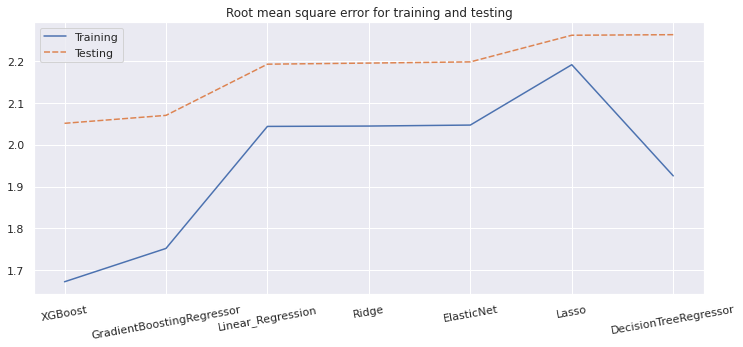

In [560]:
# order the results by testing values
rmse_scores = pd.DataFrame(rmse).sort_values(by='Testing',ascending=True)
print(rmse_scores, "\n")

fig = plt.figure(figsize=(12, 5))
sns.lineplot(data=rmse_scores)
plt.title('Root mean square error for training and testing')
plt.xticks(rotation=10)
plt.show()

XGBoost has the best rmse so let's try to improve the result of it

#### 4.3. Improvement the result of the best model <a name="heading--4-3"/>

In [544]:
# XGBoost hyperparameter optimization
xgboost_params = {
    "learning_rate":    [0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
    "max_depth":        [4, 5, 6, 7, 8, 9, 10, 12, 15],
    "min_child_weight": [1, 3, 5, 7],
    "gamma":            [0, 0.1, 0.2, 0.3, 0.4],
    "colsample_bytree": [0.3, 0.4, 0.5, 0.7]
}

In [545]:
# XGBoost hyperparameter optimization using RandomizedSearchCV
classifier = xg.XGBRegressor()

In [546]:
# Randomized search on hyper parameters
random_search = RandomizedSearchCV(classifier, param_distributions=xgboost_params, scoring='neg_root_mean_squared_error', cv=10, verbose=3)

In [547]:
random_search.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] min_child_weight=7, max_depth=7, learning_rate=0.3, gamma=0.1, colsample_bytree=0.7 
[13:27:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  min_child_weight=7, max_depth=7, learning_rate=0.3, gamma=0.1, colsample_bytree=0.7, score=-2.082, total=   1.4s
[CV] min_child_weight=7, max_depth=7, learning_rate=0.3, gamma=0.1, colsample_bytree=0.7 
[13:27:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s


[CV]  min_child_weight=7, max_depth=7, learning_rate=0.3, gamma=0.1, colsample_bytree=0.7, score=-2.342, total=   1.5s
[CV] min_child_weight=7, max_depth=7, learning_rate=0.3, gamma=0.1, colsample_bytree=0.7 
[13:27:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.9s remaining:    0.0s


[CV]  min_child_weight=7, max_depth=7, learning_rate=0.3, gamma=0.1, colsample_bytree=0.7, score=-1.909, total=   1.4s
[CV] min_child_weight=7, max_depth=7, learning_rate=0.3, gamma=0.1, colsample_bytree=0.7 
[13:27:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  min_child_weight=7, max_depth=7, learning_rate=0.3, gamma=0.1, colsample_bytree=0.7, score=-2.603, total=   1.4s
[CV] min_child_weight=7, max_depth=7, learning_rate=0.3, gamma=0.1, colsample_bytree=0.7 
[13:27:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  min_child_weight=7, max_depth=7, learning_rate=0.3, gamma=0.1, colsample_bytree=0.7, score=-1.952, total=   1.4s
[CV] min_child_weight=7, max_depth=7, learning_rate=0.3, gamma=0.1, colsample_bytree=0.7 
[13:27:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:square

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  2.6min finished


RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=1, nthread=None,
                                          objective='reg:linear',
                                          random_state=0, reg_alpha...
                   iid='deprecated', n_iter=10, n_jobs=None,
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5,
                                                   

In [548]:
random_search.best_params_

{'colsample_bytree': 0.5,
 'gamma': 0.1,
 'learning_rate': 0.05,
 'max_depth': 7,
 'min_child_weight': 5}

In [549]:
classifier = make_pipeline(RobustScaler(), StandardScaler(), 
                                         xg.XGBRegressor(colsample_bytree=0.5, 
                                                        gamma= 0.1, 
                                                        learning_rate=0.05, 
                                                        max_depth=7, 
                                                        min_child_weight=5))


In [561]:
xgboost_model = classifier.fit(X_train, y_train)
# make predictions with train and test datasets
y_pred_train = xgboost_model.predict(X_train)
y_pred_test = xgboost_model.predict(X_test)

# calculate root mean squared error for training and testing    
rmse_train, rmse_test = np.sqrt(mean_squared_error(y_train, y_pred_train)), \
np.sqrt(mean_squared_error(y_test, y_pred_test))

rmse_xgboost_before_tun_train = rmse['Training']['XGBoost']
rmse_xgboost_before_tun_test = rmse['Testing']['XGBoost']

print('XGBoost:')
print(f'Training RMSE before tuning the hyperparameters: {rmse_xgboost_before_tun_train}')
print(f'Training RMSE after tuning the hyperparameters: {rmse_train}','\n')
print(f'Testing RMSE before tuning the hyperparameters: {rmse_xgboost_before_tun_test}')
print(f'Testing RMSE after tuning the hyperparameters: {rmse_test}','\n')

[14:11:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBoost:
Training RMSE before tuning the hyperparameters: 1.6729621348590087
Training RMSE after tuning the hyperparameters: 1.1912171310900879 

Testing RMSE before tuning the hyperparameters: 2.05072510494478
Testing RMSE after tuning the hyperparameters: 2.043544513336798 



In [563]:
# Predictions with XGBoost Regressor
y_pred = xgboost_model.predict(test)
y_pred = np.expm1(y_pred)
submission = pd.DataFrame({'Id': test_id, 'Revenue': y_pred})
submission.head()

,Id,Revenue
0,3001,8328476.0000
1,3002,1062903.0000
2,3003,10135141.0000
3,3004,8108893.0000
4,3005,364014.8125


In [ ]:
# to submit the file on kaggle
# submission.to_csv('submission.csv', index=False, header=True)